2017 Edition

# Anomaly Detection in Network Traffic with K-means clustering

We can categorize machine learning algorithms into two main groups: **supervised learning** and **unsupervised learning**. With supervised learning algorithms, in order to predict unknown values for new data, we have to know the target value for many previously-seen examples. In contrast, unsupervised learning algorithms explore the data which has no target attribute to find some intrinsic structures in them.

Clustering is a technique for finding similar groups in data, called **clusters**. Clustering is often called an unsupervised learning task as no class values denoting an a priori grouping of the data instances are given.

In this notebook, we will use K-means, a very well-known clustering algorithm to detect anomaly network connections based on statistics about each of them. A thorough overview of K-means clustering, from a research perspective, can be found in the following wonderful [tutorial](http://theory.stanford.edu/~sergei/slides/kdd10-thclust.pdf).

## Goals
We expect students to:
* Learn (or revise) and understand the K-means algorithm
* Implement a simple K-means algorithm
* Use K-means to detect anomalies network connection data

## Steps

1. In section 1, we will have an overview about K-means then implement a simple version of it.
2. In section 2, we build models with and without categorical features.
3. Finally, in the last section, using our models, we will detect unusual connections.

# 1. K-means
## 1.1. Introduction
Clustering is a typical and well-known type of unsupervised learning. Clustering algorithms try to find natural groupings in data. Similar data points (according to some notion of similarity) are considered in the same group. We call these groups **clusters**.

K-Means clustering is a simple and widely-used clustering algorithm. Given value of $k$, it tries to build $k$ clusters from samples in the dataset. Therefore, $k$ is an hyperparameter of the model. The right value of $k$ is not easy to determine, as it highly depends on the data set and the way that data is featurized.

To measure the similarity between any two data points, K-means requires the definition of a distance function between data points. What is a distance? It is a value that indicates how close two data points are in their space. In particular, when data points lie in a $d$-dimensional space, the Euclidean distance is a good choice of a distance function, and is supported by MLLIB.

In K-means, a cluster is a group of points, with a representative entity called a centroid. A centroid is also a point in the data space: the center of all the points that make up the cluster. It's defined to be the arithmetic mean of the points. In general, when working with K-means, each data sample is represented in a $d$-dimensional numeric vector, for which it is easier to define an appropriate distance function. As a consequence, in some applications, the original data must be transformed into a different representation, to fit the requirements of K-means.

## 1.2. How does it work?
Given $k$, the K-means algorithm works as follows:

1. Randomly choose $k$ data points (seeds) to be the initial centroids
2. Assign each data point to the **closest centroid**
3. Re-compute (update) the centroids using the current cluster memberships
4. If a convergence criterion is not met, go to step 2

We can also terminate the algorithm when it reaches an iteration budget, which yields an approximate result.
From the pseudo-code of the algorithm, we can see that K-means clustering results can be sensitive to the order in which data samples in the data set are explored. A sensible practice would be to run the analysis several times, randomizing objects order; then, average the cluster centers of those runs and input the centers as initial ones for one final run of the analysis.

## 1.3. Illustrative example
One of the best ways to study an algorithm is trying implement it.
In this section, we will go step by step to implement a simple K-means algorithm.

### Question 1

#### Question 1.1
<div class="alert alert-info">

Complete the below function to calculate an Euclidean distance between any two points in $d$-dimensional data space

</div>

In [1]:
import numpy as np
import time

# calculate distance between two d-dimensional points
def euclidean_distance(p1, p2):
    return np.linalg.norm(np.array(p1)-np.array(p2))

# test our function
assert (round(euclidean_distance([1,2,3] , [10,18,12]), 2) == 20.45), "Function's wrong"

t0 = time.time()
for _ in np.arange(10000):
    euclidean_distance([1,2,3] , [10,18,12])

print(time.time()-t0)

0.17371606826782227


<div class="alert alert-success">
<b><i>What is the euclidean distance?</i></b>
<br><br>
The euclidean distance is the ordinary distance between two points in a $n$-dimensional space; in other words, it's the straight-line distance between the two points that translates into the rooted sum of the squared difference of the two points for each different dimension.
<br>
In formulas:
\begin{align}
d(\mathbf{p},\mathbf{q}) = d(\mathbf{q},\mathbf{p}) &= \sqrt{(\mathit{q}_1-\mathit{p}_1)^2+(\mathit{q}_2-\mathit{p}_2)^2+\dots+(\mathit{q}_n-\mathit{p}_n)^2} \\
&=\sqrt{\sum_{i=1}^n(\mathit{q}_i-\mathit{p}_i)^2}
\end{align}
</div>

In [2]:
def euclidean_distance(a, b, sqrt=True):
    if type(a) is not np.ndarray:
        a = np.array(a)
    if type(b) is not np.ndarray:
        b = np.array(b)
    c = a - b
    if sqrt is False:
        return c.T.dot(c)
    return np.sqrt(c.T.dot(c))

<div class="alert alert-warning">
We put a flag <code>sqrt</code> in order to make even faster the computation of the error since we would square root to power again later and those operations would simply cancel out.
</div>

In [3]:
t0 = time.time()
for _ in np.arange(10000):
    euclidean_distance([1,2,3] , [10,18,12])

print(time.time()-t0)

0.13388848304748535


<div class="alert alert-success">
Using numpy actually, we were able to improve the speed of this function and this will help us in the long computations in the final questions of the notebook.
<br><br>
The speed test was performed with simple numbers and run 10 thousand times and we can still see that numpy lowers the time taken from 14 seconds to less than 1 second but afterwards, when using this functions many more times, the difference is sensible.
</div>

#### Question 1.2
<div class="alert alert-info">

Given a data point and the current set of centroids, complete the function below to find the index of the closest centroid for that data point.

</div>

In [4]:
def find_closest_centroid(datapoint, centroids):
    # find the index of the closest centroid of the given data point.
    distances = [euclidean_distance(datapoint, _) for _ in centroids]
    return np.argmin(distances)

assert(find_closest_centroid( [1,1,1], [ [2,1,2], [1,2,1], [3,1,2] ] ) == 1), "Function's wrong"

#### Question 1.3
<div class="alert alert-info">

Write a function to randomize `k` initial centroids.

</div>

In [5]:
np.random.seed(22324)

# randomize initial centroids
def randomize_centroids(data, k):
    centroids = data
    np.random.shuffle(centroids)
    return centroids[:k]

assert(len(
    randomize_centroids(np.array([np.array([2,1,2]), np.array([1,2,1]), np.array([3,1,2])]), 
        2)) == 2), "Wrong function"

#### Question 1.4
<div class="alert alert-info">

Write function `check_converge` to check the stop criteria of the algorithm.

</div>

In [6]:
MAX_ITERATIONS = 5

# return True if clusters have converged , otherwise, return False  
def check_converge(centroids, old_centroids, num_iterations, threshold=0):
    # if it reaches an iteration budget
    if num_iterations > MAX_ITERATIONS:
        return True
    # check if the centroids don't move (or very slightly)
    dist = [euclidean_distance(curr, old) for curr, old in zip(centroids, old_centroids)]
    if all(dist[x]<threshold for x in range(len(dist))):
        return True
    return False

#### Question 1.5
<div class="alert alert-info">

Write function `update_centroid` to update the new positions for the current centroids based on the position of their members.

</div>

In [7]:
# centroids: a list of centers
# cluster: a list of k elements. Each element i-th is a list of data points that are assigned to center i-th
def update_centroids(centroids, cluster):
    for i, c in enumerate(cluster):
        centroids[i] = sum(c)/len(c)
    return centroids

#### Question 1.6
<div class="alert alert-info">

Complete the K-means algorithm skeleton below, with the functions you wrote above.

</div>

In [8]:
# data : set of data points
# k : number of clusters
# centroids: initial list of centroids
def kmeans(data, k=2, centroids=None):
    
    # randomize the centroids if they are not given
    if not centroids:
        centroids = randomize_centroids(data, k)

    old_centroids = centroids[:]

    iterations = 0
    while True:
        iterations += 1

        # init empty clusters
        clusters = [[] for i in range(k)]

        # assign each data point to the closest centroid
        for point in data:
            # find the closest center of each data point
            centroid_idx = find_closest_centroid(point, centroids)
            
            # assign datapoint to the closest cluster
            clusters[centroid_idx].append(point)
        
        # keep the current position of centroids before changing them
        old_centroids = centroids[:]
        
        # update centroids
        centroids = update_centroids(clusters, clusters)
        
        # if the stop criteria are met, stop the algorithm
        if check_converge(centroids, old_centroids, iterations):
            break
    
    return centroids

Next, we will test our algorithm on [Fisher's Iris dataset](http://en.wikipedia.org/wiki/Iris_flower_data_set), and plot the resulting clusters in 3D.

#### Question 1.7
<div class="alert alert-info">

The code below can be used to test your algorithm with three different datasets: `Iris`, `Moon` and `Blob`.
Run your algorithm to cluster datapoints in these datasets, plot the results and discuss about them. Do you think that our algorithm works well? Why?

</div>

In [9]:
import warnings
warnings.filterwarnings('ignore')

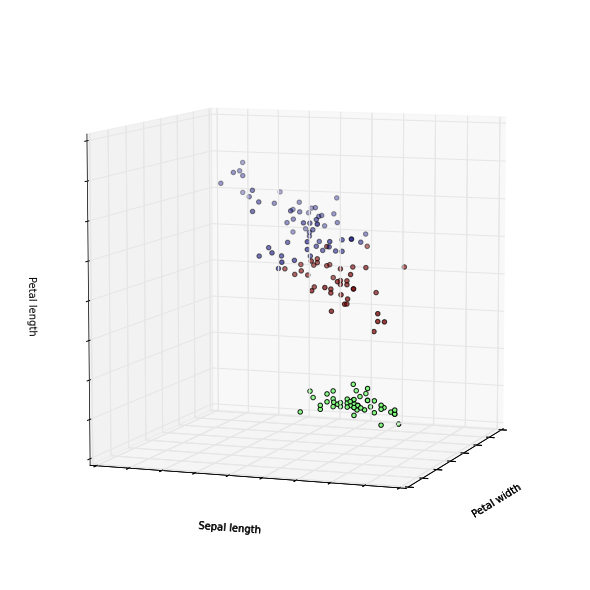

In [11]:
# the sourcecode in this cell is inspired from 
# https://gist.github.com/bbarrilleaux/9841297

%matplotlib inline

from sklearn import datasets, cluster
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# load data
iris = datasets.load_iris()
X_iris = iris.data
y_iris = iris.target
# do the clustering
centers = kmeans(X_iris, k=3)
labels = [find_closest_centroid(p, centers) for p in X_iris]

#plot the clusters in color
fig = plt.figure(1, figsize=(8, 8))
plt.clf()
ax = Axes3D(fig, rect=[0, 0, 1, 1], elev=8, azim=200)
plt.cla()
ax.scatter(X_iris[:, 3], X_iris[:, 0], X_iris[:, 2], c=labels)

ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([])
ax.set_xlabel('Petal width')
ax.set_ylabel('Sepal length')
ax.set_zlabel('Petal length')

plt.show()

# Here we use sci-kit learn implementation of K-means
# centers =cluster.KMeans(n_clusters=3)
# centers.fit(X_iris) 
# labels = centers2.labels_


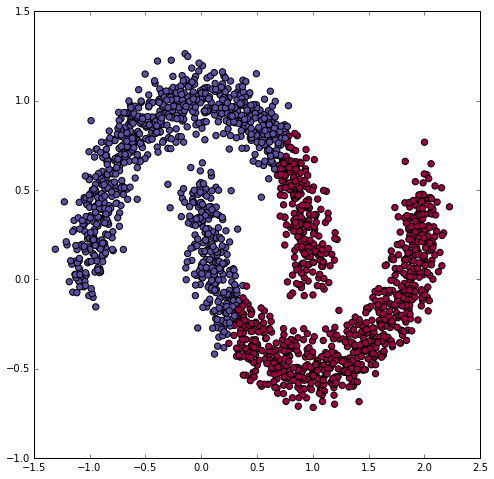

In [11]:
# moon
np.random.seed(0)
X, y = datasets.make_moons(2000, noise=0.1)

centers = kmeans(X, k=2)
labels = [find_closest_centroid(p, centers) for p in X]

fig = plt.figure(1, figsize=(8, 8))
plt.clf()
plt.scatter(X[:,0], X[:,1], s=40, c=labels, cmap=plt.cm.Spectral)

plt.show()

<div class="alert alert-success">
With this dataset, we can clearly see one of the main problems of the clustering technique. The visual division of the two clusters is totally different than the effective division computed by the algorithm.
</div>

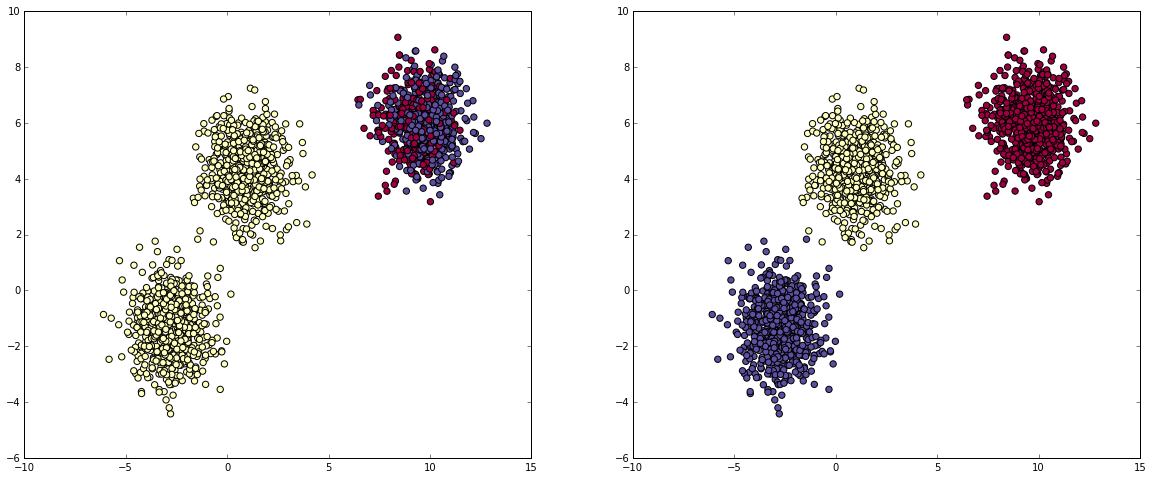

In [12]:
# blob
np.random.seed(0)
X, y = datasets.make_blobs(n_samples=2000, centers=3, n_features=20, random_state=0)

centers = kmeans(X, k=3)
labels = [find_closest_centroid(p, centers) for p in X]

plt.figure(1, figsize=(20, 8))
plt.subplot("121")
plt.scatter(X[:,0], X[:,1], s=40, c=labels, cmap=plt.cm.Spectral)

# blob with randomized initial centers
centers = kmeans(X, k=3)
labels = [find_closest_centroid(p, centers) for p in X]

plt.subplot("122")
plt.scatter(X[:,0], X[:,1], s=40, c=labels, cmap=plt.cm.Spectral)

plt.show()

<div class="alert alert-success">
The blob dataset above shows another problem with clustering. The left plot represents the data clusterized in 3 clusters with the centroids initialized with a random seed set to 0. The right plot instead has no constraints on the initial centroids and so they are always chosen randomly.
<br><br>
This example shows us that the effectivness and the accuracy of the clustering technique is highly dependant on different factors and one of them is the choice of the initial centroids.
</div>

That's enough about K-means for now. In the next section, we will apply MMLIB's K-means on Spark to deal with a large data in the real usecase.


# 2. Usecase: Network Intrusion 

Some attacks attempt to flood a computer with network traffic. In some other cases, attacks attempt to exploit flaws in networking software in order to gain unauthorized access to a computer. Detecting an exploit in an incredibly large haystack of network requests is not easy.

Some exploit behaviors follow known patterns such as scanning every port in a short of time, sending a burst of request to a port... However, the biggest threat may be the one that has never been detected and classified yet. Part of detecting potential network intrusions is detecting anomalies. These are connections that aren't known to be attacks, but, do not resemble connections that have been observed in the past.

In this notebook, K-means is used to detect anomalous network connections based on statistics about each of them.


## 2.1. Data
The data comes from [KDD Cup 1999](http://kdd.ics.uci.edu/databases/kddcup99/kddcup99.html). The dataset is about 708MB and contains about 4.9M connections. For each connection, the data set contains information like the number of bytes sent, login attempts, TCP errors, and so on. Each connection is one line of CSV-formatted data, containing 38 features: back, buffer_overflow, ftp_write, guess_passwd, imap, ipsweep, land, loadmodule, multihop, neptune, nmap, normal, perl, phf, pod, portsweep, rootkit, satan, smurf, spy, teardrop, warezclient, warezmaster. For more details about each feature, please follow this [link](http://kdd.ics.uci.edu/databases/kddcup99/kddcup99.html).

Many features take on the value 0 or 1, indicating the presence or absence of a behavior such as `su_attempted` in the 15th column. Some features are counts, like `num_file_creations` in the 17th columns. Some others are the number of sent and received bytes.

## 2.2. Clustering without using categorical features

First, we need to import some packages that are used in this notebook.

In [12]:
import os
import sys
import re
from pyspark import SparkContext
from pyspark import SparkContext
from pyspark.sql import SQLContext
from pyspark.sql.types import *
from pyspark.sql import Row
from pyspark.sql.functions import *
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pyspark.sql.functions as func
import matplotlib.patches as mpatches
from pyspark.mllib.clustering import KMeans, KMeansModel
from operator import add
import seaborn as sns

input_path = "/datasets/k-means/kddcup.data"
raw_data = sc.textFile(input_path, 12)

### 2.2.1. Loading data

There are two types of features: numerical features and categorical features.
Currently, to get familiar with the data and the problem, we only use numerical features. In our data, we also have pre-defined groups for each connection, which we can use later as our "ground truth" for verifying our results.

**Note 1**: we don't use the labels in the training phase!!!

**Note 2**: in general, since clustering is un-supervised, you don't have access to ground truth. For this reason, several metrics to judge the quality of clustering have been devised. For a short overview of such metrics, follow this [link](https://en.wikipedia.org/wiki/Cluster_analysis#Internal_evaluation). Note that computing such metrics, that is trying to assess the quality of your clustering results, is as computationally intensive as computing the clustering itself!

#### Question 2
<div class="alert alert-info">

Write function `parseLine` to construct a tuple of `(label, vector)` for each connection, extract the data that contains only the data points (without label), then print the number of connections.

</div>

Where,

* `label` is the pre-defined label of each connection
* `vector` is a numpy array that contains values of all features, but the label and the categorial features at index `1,2,3` of each connection. Each `vector` is a data point.

In [13]:
def parseLine(line):
    cols = line.split(",")
    # label is the last column
    label = cols[-1]
    
    # vector is every column, except the label
    vector = cols[:-1]
    
    # delete values of columns that have index 1->3 (categorical features)
    vector = [x for i, x in enumerate(vector) if i not in [1, 2, 3]]
    
    # convert each value from string to float
    vector = np.array(vector, dtype=np.float)
    
    return (label, vector)

labelsAndData = raw_data.map(parseLine).cache()

# we only need the data, not the label
data = labelsAndData.map(lambda x : x[1]).cache()

# number of connections
n = data.count()

In [15]:
print("Number of connections:", n)
print("Details per connection:", len(data.first()))

Number of connections: 4898431
Details per connection: 38


<div class="alert alert-success">
For this initial part, we are not considering the categorical features in indexes 1,2 and 3 that are:
<br>
<ul>
<li>protocol type
<li>service
<li>flag
</ul>
<br>
We have approx. 5 million connections. Let's see how the data is divided.
</div>

In [16]:
x = labelsAndData.map(lambda x: x[0]).distinct().count()
print("Total number of labels:\n", x)
y = labelsAndData.map(lambda x : (x[0], 1)).reduceByKey(add).collect()
#print("The labels available and their occurrence in the dataset is:\n")
#for _ in y:
#    print("%20s\t%d" %(_[0], _[1]))

Total number of labels:
 23


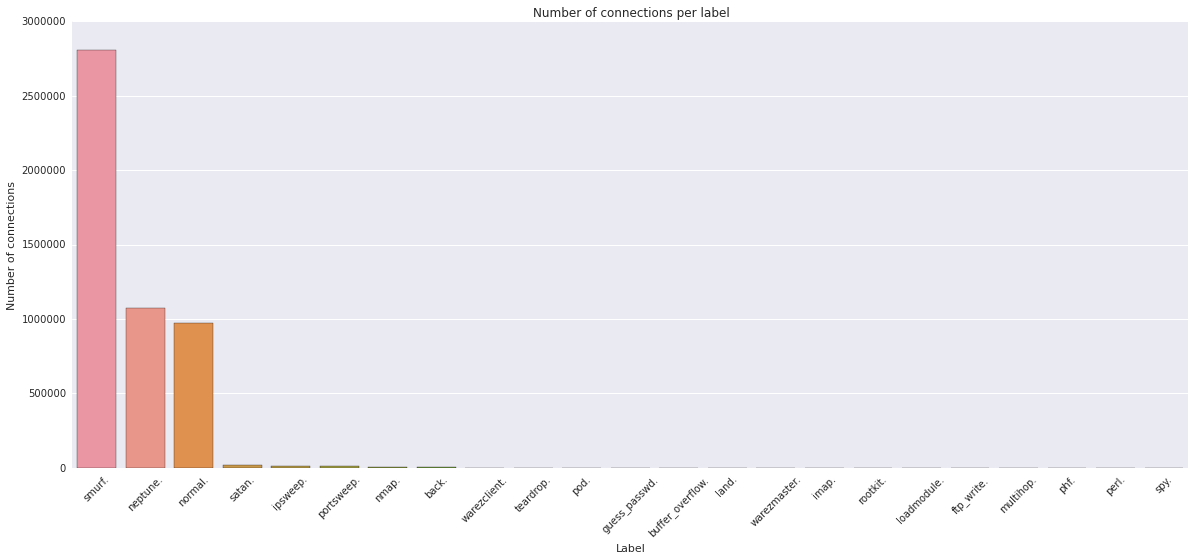

In [17]:
y.sort(key=lambda x : x[1], reverse=True)
plt.figure(figsize=(20,8))
sns.barplot(x=np.arange(len(y)), y=[_[1] for _ in y])
plt.xticks(np.arange(len(y)), [_[0] for _ in y], rotation=45)
plt.xlabel("Label")
plt.ylabel("Number of connections")
plt.title("Number of connections per label")
plt.show()

In [18]:
#amount of connections of the first 3 labels.
print("amount of connections of the first 3 labels:\t", y[0][1]+y[1][1]+y[2][1])

amount of connections of the first 3 labels:	 4852684


<div class="alert alert-success">
There are 23 different labels but actually we can immediately see that the data is not equally divided.
<br><br>
Of the nearly 5 million connections, more than a half are labelled as <i>smurf</i> and other 2 millions are equally divided as <i>neptune</i> and <i>normal</i>. We computed above the amount of connections that this first 3 labels amount for.
<br>
As we can see, of the 4898431, 4852684 are dedicated to just 3 labels leaving less than 40 thousand connections to the remaining 20 labels.
<br><br>
This initial look inside the data may hint us on how the data is divided in the space: since so much data has the same label, probably it will be packed up together and leave all the other labels as "outliers".

</div>

#### Question 3
<div class="alert alert-info">

Using K-means algorithm of MLLIB, cluster the connections into two groups then plot the result. Why two groups? In this case, we are just warming up, we're testing things around, so "two groups" has no particular meaning.

</div>  

You can use the following parameters:  

<ul>

  <li>`maxIterations=10`</li>
  <li>`runs=10`</li>
  <li>`initializationMode="random"`</li>

</ul>  

Discuss the result from your figure.

In [19]:
clusters = KMeans.train(data, 2, maxIterations=10, runs=10, initializationMode="random")

<div class="alert alert-success">
Each connection has 38 attributes. If we want to cluster the data we have to decide which are the best features to use on the axis to plot the data. For this first example, let's simply use the first 3 features to do a 3D plot.
<br><br>
Let's first see how the data is divided.
</div>

In [20]:
from operator import add

__ = labelsAndData.map(lambda x : (clusters.predict(x[1]), 1)).reduceByKey(add).collect()
for _ in __:
    print("Cluster %5d\tNumber of elements: %10d" %(_[0], _[1]))

Cluster     0	Number of elements:          5
Cluster     1	Number of elements:    4898426


<div class="alert alert-success">
In our tests, we got completely random results; the first time we run the training, we got the 5 million connections divided almost equally; the second time we got all connections but 5 in one cluster and 5 connections of label "portsweep" in the second cluster; while the third time we have all connections in one cluster and none in the second one.
<br><br>
This is an evidence of two things:
<br>
<ul>
<li>Clustering main problem of centroid initializations
<li>Curse of dimensionality that can be the explanation of the random results we get; the majority of the data is stuck together and goes inside the same cluster.
</ul>
<br>
<br>
We'll try now to plot the data.
</div>

<div class="alert alert-success">
First of all we get the values of the 3 axis, and then we scatter the plots. We will not plot all of the 4 million connections but only a subset of those.
<br><br>
As of now, we will just use the first 3 attributes as the first axis.
</div>

In [21]:
sampled = data.sample(withReplacement=False, fraction=0.01)
datax = sampled.map(lambda x: x[0]).collect()
datay = sampled.map(lambda x: x[1]).collect()
dataz = sampled.map(lambda x: x[2]).collect()
labels_ = sampled.map(lambda x: clusters.predict(x)).collect()

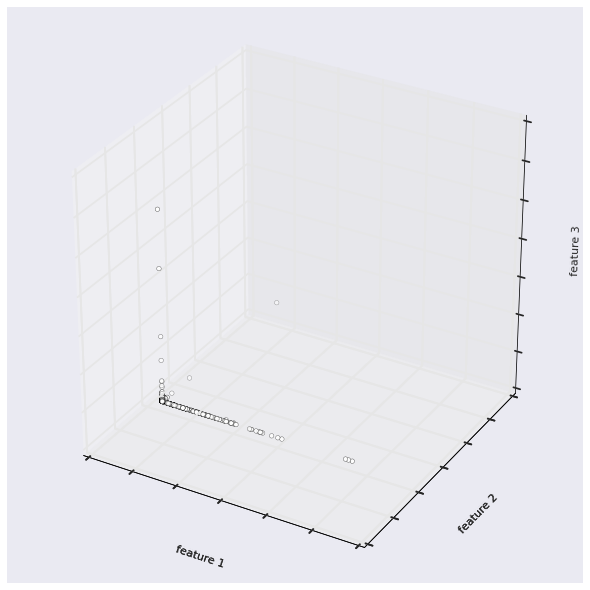

In [22]:
#plot the clusters in color
fig = plt.figure(1, figsize=(8, 8))
plt.clf()
ax = Axes3D(fig)
plt.cla()

ax.scatter(datax, datay, dataz, c=labels_)

ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([])
ax.set_xlabel('feature 1')
ax.set_ylabel('feature 2')
ax.set_zlabel('feature 3')

plt.show()

<div class="alert alert-success">
Also the plot above doesn't make a lot of sense but that is just the case because we plotted the first values on 3 random axis.
<br><br>
A relevant information that we can get from this plot, even though it plots only the first 1000 connections data, is that feature 2 is almost the same (other than the point on the right side) for every point and so maybe this feature don't contain much information.
<br><br>
A good technique to get the best features and to understand how much of the information is contained in them is to use PCA.
</div>

<div class="alert alert-warning">
<h3>Principal Component Analysis</h3>
</div>

In [23]:
from pyspark.mllib.linalg import Vectors
from pyspark.mllib.feature import PCA as PCAmllib

vectorData = data.map(Vectors.dense)
PCAModel3 = PCAmllib(3).fit(vectorData)
pcaData3 = PCAModel3.transform(vectorData).sample(withReplacement=False, fraction=0.01).collect()

PCAModel2 = PCAmllib(2).fit(vectorData)
pcaData2 = PCAModel2.transform(vectorData).sample(withReplacement=False, fraction=0.01).collect()

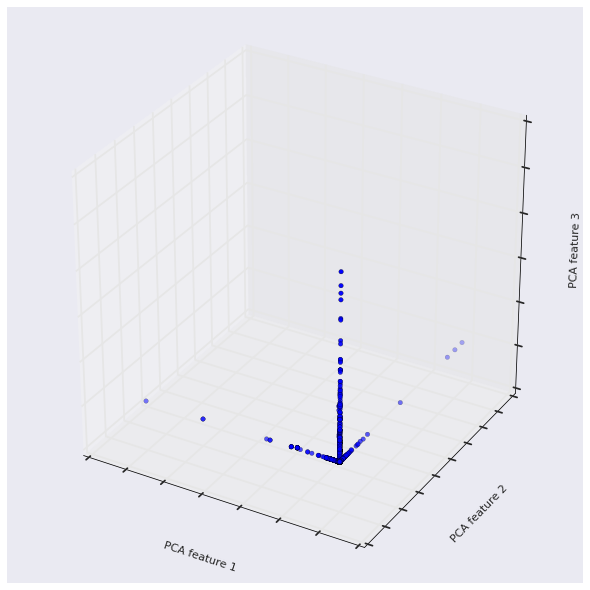

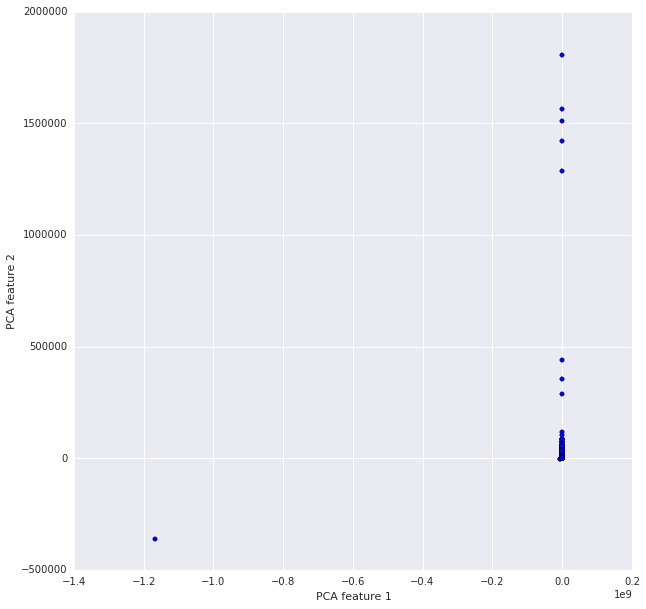

In [24]:
#pca plot
fig = plt.figure(1, figsize=(8, 8))
ax = Axes3D(fig)

ax.scatter([x[0] for x in pcaData3], [x[1] for x in pcaData3], [x[2] for x in pcaData3])

ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([])
ax.set_xlabel('PCA feature 1')
ax.set_ylabel('PCA feature 2')
ax.set_zlabel('PCA feature 3')
plt.show()

fig = plt.figure(1, figsize=(10, 10))

plt.scatter([x[0] for x in pcaData2], [x[1] for x in pcaData2])

ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
plt.xlabel('PCA feature 1')
plt.ylabel('PCA feature 2')

plt.show()

<div class="alert alert-success">
Above are the plots of the Principal Component Analysis did with k=3 and k=2.
<br><br>
First of all, <b>what is PCA?</b> It is a procedure to transform a set of variables, possibly correlated, into another set of uncorrelated variables called principal components (they are all orthogonal to each other, as we can see from the first plot). The number of principal components is less or equal to the number of initial variables and this technique is really useful when we want to reduce dimensionality. If we start for example with 38 dimensions, after the transformation we get a set of principal components and, according to the number of dimensions we want, we get the first k principal components. And why do we get the first and not random ones? Because the transformation is defined in such a way that the principal components are ordered with respect to how much variability of the data they account for.
<br><br>
Looking at the first plot, the one where we used 3 principal components, we can see that the majority of the data is packed up at the intersection of the 3 axis and that the data lies especially on the z-axis. This means that, even though we used 3 principal components, 2 of them don't have really high variance and in fact they don't show too much data.
<br><br>
The same happens for the second plot where we use just two components, and the data is still packed together in (0,0).
<br><br>
We used the PCA function in the <code>MLLib</code> library otherwise it would have been impossibile to compute it in the full dataset.<br>
Actually, when we initially tried to use PCA on a small sample of data and we managed to use the PCA function in the <code>sklearn</code> library, we had the possibility to understand the amount of variance with the <code>explained_variance_ratio</code> function and we discovered that with just three principal components, more than 95 percent of the information was represented. 
<br>
This is a proof of what we saw before analyzing the data: that since so much of the data is represented with just 3 labels, it will be all packed together.
</div>

### 2.2.3. Evaluating model

#### Question 4
<div class="alert alert-info">

One of the simplest method to evaluate our result is calculate the Within Set Sum of Squared Errors (WSSSE), or simply, 'Sum of Squared Errors'. An error of a data point is defined as it's distance to the closest cluster center.

</div>


In [16]:
import time

# Evaluate clustering by computing Within Set Sum of Squared Errors
def error(clusters, point):
    closest_center = clusters.centers[clusters.predict(point)]
    return euclidean_distance(closest_center, point, sqrt=False)

In [26]:
t1 = time.time()
WSSSE = data.map(lambda x : error(clusters, x)).reduce(add)
print("Within Set Sum of Squared Error = " + str(WSSSE))
print("Time needed:", time.time()-t1)

Within Set Sum of Squared Error = 3.05254895755e+18
Time needed: 8.434321403503418


In [27]:
t1 = time.time()
print(clusters.computeCost(data))
print("Time needed:", time.time()-t1)

3.052548957548266e+18
Time needed: 2.723449468612671


<div class="alert alert-success">
In the KMeans documentation, we found a method called <code>public double computeCost(RDD&lt;Vector&gt; data)</code> that actually computer the same information but in a much faster way.
<br>
We wrote the time of both methods and the improving factor is approximately 10.
</div>


#### Question 5

<div class="alert alert-info">

This is a good opportunity to use the given labels to get an intuitive sense of what went into these two clusters, by counting the labels within each cluster. Complete the following code that uses the model to assign each data point to a cluster, and counts occurrences of cluster and label pairs.  

What do you think about the result?

</div>

In [28]:
clusterLabelCount = labelsAndData.map(lambda x : ((clusters.predict(x[1]), x[0]), 1)).reduceByKey(add).collect()

for item in clusterLabelCount:
    print("Label #%d\tClass:%20s\tOccurrences:%10d" %(item[0][0],item[0][1],item[1]))

Label #1	Class:               back.	Occurrences:      2203
Label #1	Class:               imap.	Occurrences:        12
Label #1	Class:           teardrop.	Occurrences:       979
Label #1	Class:                pod.	Occurrences:       264
Label #1	Class:              satan.	Occurrences:     15892
Label #1	Class:          portsweep.	Occurrences:     10408
Label #1	Class:               land.	Occurrences:        21
Label #1	Class:       guess_passwd.	Occurrences:        53
Label #1	Class:           multihop.	Occurrences:         7
Label #1	Class:            neptune.	Occurrences:   1072017
Label #1	Class:              smurf.	Occurrences:   2807886
Label #1	Class:             normal.	Occurrences:    972781
Label #1	Class:               nmap.	Occurrences:      2316
Label #1	Class:        warezmaster.	Occurrences:        20
Label #1	Class:                phf.	Occurrences:         4
Label #1	Class:                spy.	Occurrences:         2
Label #1	Class:         loadmodule.	Occurrences:        

In [29]:
nrLabelsPerCluster = labelsAndData.map(lambda x : (clusters.predict(x[1]), x[0])).groupByKey().collect()
for _ in nrLabelsPerCluster:
    print("Cluster %5d\tNumber of classes: %10d" %(_[0], len(np.unique(_[1].data))))

Cluster     0	Number of classes:          1
Cluster     1	Number of classes:         23


<div class="alert alert-success">
As we can see from this results, all of the data but 5 elements goes in one cluster while 5 elements labeled as <i>portsweep</i> go in the second cluster. (at least that was the result at the time of the comment but sometimes as we said before the result are different).
<br>
One cluster usually gets almost all the classes while the other one gets 1 or 0 classes (portsweep, more specifically).
<br><br>
The clusters are heavily unbalanced due to the disparity of the whole dataset and this tells us one important thing: that the majority of the point is stuck together and there is a really small amount of outliers (only 5 were recognized). There are surely more than 5 outliers but they hide for sure inside the first cluster.
<br><br>
The choice of k=2 could be better adapted; since there are 23 classes, it would make much more sense to use k=23 or more.
</div>

### 2.2.4. Choosing K

How many clusters are appropriate for a dataset? In particular, for our own dataset, it's clear that there are 23 distinct behavior patterns in the data, so it seems that k could be at least 23, or likely, even more. In other cases, we even don't have any information about the number of patterns at all (remember, generally your data is not labelled!). Our task now is finding a good value of $k$. For doing that, we have to build and evaluate models with different values of $k$. A clustering could be considered good if each data point were near to its closest centroid. One of the ways to evaluate a model is calculating the Mean of Squared Errors of all data points.

#### Question 6
<div class="alert alert-info">
Complete the function below to calculate the MSE of each model that is corresponding to each value of $k$.  


Plot the results. From the obtained result, what is the best value for $k$? Why?

</div>

In [17]:
# k: the number of clusters
def clusteringScore(data, k, withCenters=False):
    clusters = KMeans.train(data, k, maxIterations=10, runs=10, initializationMode="random")
    # calculate mean square error
    if withCenters is True:
        return (clusters.computeCost(data), len(clusters.centers))
    return clusters.computeCost(data)

In [31]:
k_vector = [2,5,10,23,30,50,70,100,120,200,300,400]

scores = [clusteringScore(data, k, withCenters=True) for k in k_vector]
for i, score in enumerate(scores):
    print("k = %3d, (effective nr. of clusters = %3d) WSSSE = %d" %(k_vector[i], score[1], score[0]))

k =   2, (effective nr. of clusters =   2) WSSSE = 3052548957548265984
k =   5, (effective nr. of clusters =   3) WSSSE = 1165055747241957632
k =  10, (effective nr. of clusters =   8) WSSSE = 1141231518310268544
k =  23, (effective nr. of clusters =  15) WSSSE = 1094457306808989312
k =  30, (effective nr. of clusters =  14) WSSSE = 1093797986727370240
k =  50, (effective nr. of clusters =  31) WSSSE = 990633455756980224
k =  70, (effective nr. of clusters =  33) WSSSE = 990488175126415360
k = 100, (effective nr. of clusters =  52) WSSSE = 706460763721352448
k = 120, (effective nr. of clusters =  71) WSSSE = 990455560770611840
k = 200, (effective nr. of clusters =  92) WSSSE = 965922559392288256
k = 300, (effective nr. of clusters = 143) WSSSE = 965937153443887104
k = 400, (effective nr. of clusters = 189) WSSSE = 965927656873110912


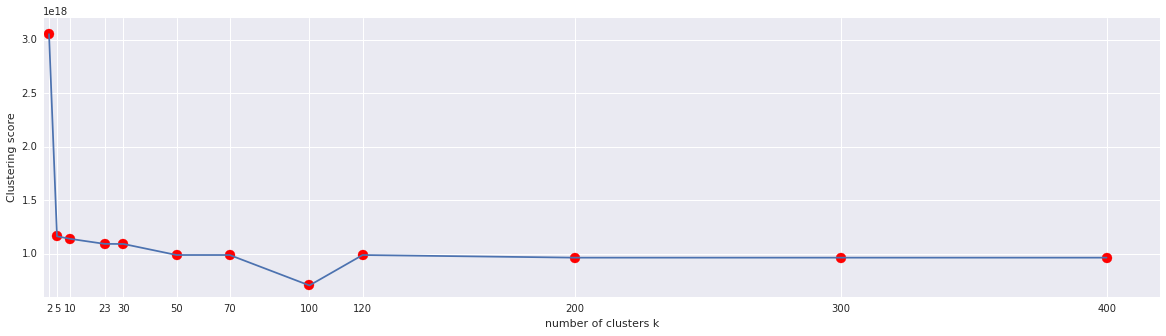

In [32]:
# plot results
plt.figure(figsize=(20,5))
_ = [_[0] for _ in scores]
plt.scatter(k_vector, _, color="r", s=100)
plt.plot(k_vector, _)
plt.axis([0, np.max(k_vector)*1.05, 0.85*np.min(_), 1.05*np.max(_)])
plt.xlabel("number of clusters k")
plt.ylabel("Clustering score")
plt.xticks(k_vector)
plt.show()

<div class="alert alert-success">
We tried a different increasing number of clusters and we plotted the results above.
<br>
As we can see from the plot and more importantly, as we know from the theory, increasing the number of clusters improves the clustering score. And this is quite obvious because if we put a huge number of clusters, for example the same as the number of points in the dataset, each point will be in its own cluster and the distance from the center will be zero. This is why simply increasing k to improve our clustering is not an efficient and sensible choice and we should find a compromise between number of clusters and clustering score.
<br><br>
The plot shows us that the initial choice of k=2 was absolutely nonsense being that the clustering score is really high with respect to the rest of the tests. The same applies for k=5 but afterwards we have a huge drop when we test the KMeans with k=10. From k=10 onwards, the clustering score doesn't decrease anymore in a consistent way and so going further than 10/23 clusters doesn't seem to be a good choice.
<br><br>
This actually makes sense if we think about the data we are clustering: we have 23 different labels but actually many of them are pretty similiar and with similiar attributes and so when we use less clusters, they still stay packed together and increasing the clusters will just make more clusters really near to each other not improving the clustering score.
<br><br>
Other than simply looking at the plot, another more methodological solution could have been to apply the <a href="http://erikerlandson.github.io/blog/2016/08/03/x-medoids-using-minimum-description-length-to-identify-the-k-in-k-medoids/">Minimum Description Length Principle</a> that tries to find the best optimization for k.
</div>

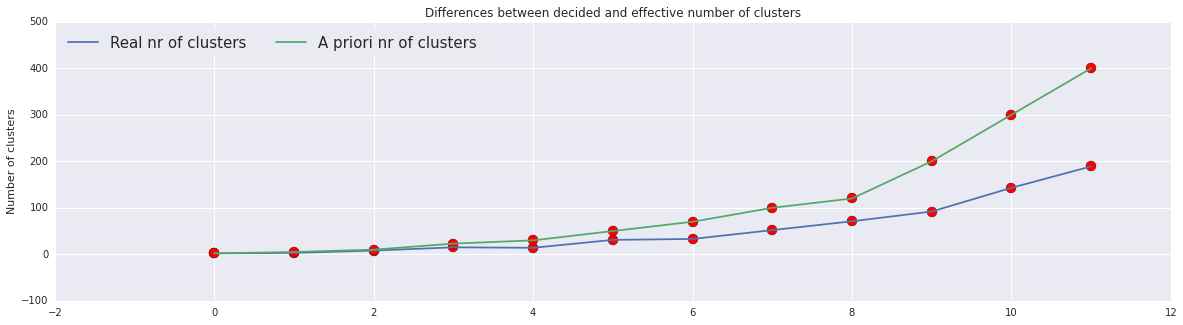

In [33]:
# plot results
plt.figure(figsize=(20,5))
_ = [_[1] for _ in scores]
plt.scatter(np.arange(len(k_vector)), _, c="r", s=100)
plt.scatter(np.arange(len(k_vector)), k_vector, c="r", s=100)
plt.plot(np.arange(len(k_vector)), _, label="Real nr of clusters")
plt.plot(np.arange(len(k_vector)), k_vector, label="A priori nr of clusters")
plt.ylabel("Number of clusters")
#plt.xticks(np.arange(len(k_vector)), k_vector)
plt.title("Differences between decided and effective number of clusters")
plt.legend(ncol=2, loc='upper left', frameon=True, fontsize=15)
#for i in np.arange(len(k_vector)):
#        plt.annotate(str(_[i]), i*0.98, _[i]*0.98)
#        plt.annotate(str(k_vector[i]), i*1.01, k_vector[i]*1.01)
plt.show()

<div class="alert alert-success">
We tried to go further in details on the previous plot and, knowing from theory that increasing the number of clusters usually improves the error, we were wondering why the clusteringScore stayed the same after a certain point.
<br><br>
In the plot above, we decided to plot the number of clusters per run, k, together with the effective number of clusters. <b><i>What do we mean with effective number of clusters?</i></b> When the kmeans algorithm runs, the various points change cluster as the centers get updated. If, after reassigning the points, one of the cluster becomes empty, it is deleted from the list of clusters.
<br><br>
As we can see from the plot above, when the number of clusters is small, none of them is deleted but, as we increase the number of clusters, the effective number of clusters doesn't increase with the same pace and this is why the clusteringScore doesn't improve a lot. The trend is that after 20 clusters, approximately half of the desired clusters gets deleted. We can see this from the slope and also from the detailed numbers in the printing above that:
<ul>
<li>30 drops to 11
<li>50 -> 26
<li>70 -> 38
<li>100 -> 48
<li>120 -> 60
<li>...
<li>400 -> 190
</ul>
</div>

### 2.2.5 Normalizing features

K-means clustering treats equally all dimensions/directions of the space and therefore tends to produce more or less spherical (rather than elongated) clusters. In this situation, leaving variances uneven is equivalent to putting more weight on variables with smaller variance, so clusters will tend to be separated along variables with greater variance.

In our notebook, since Euclidean distance is used, the clusters will be influenced strongly by the magnitudes of the variables, especially by outliers. Normalizing will remove this bias. 

Each feature can be normalized by converting it to a standard score. This means subtracting the mean of the feature’s values from each value, and dividing by the standard deviation

$normalize_i=\frac{feature_i - \mu_i}{\sigma_i}$

Where,

* $normalize_i$ is the normalized value of feature $i$
* $\mu_i$ is the mean of feature $i$
* $\sigma_i$ is the standard deviation of feature $i$


#### Question 7
<div class="alert alert-info">

Complete the code below to normalize the data. Print the first 5 lines of the new data.

</div>

<div class="label label-success">HINT</div> If $\sigma_i = 0$ then $normalize_i=feature_i - \mu_i$

In [18]:
def normalizeData(labelsAndData):
     # calculate means
    means = labelsAndData.map(lambda x:x[1]).mean()
    # calculate standard deviation of each feature
    stdevs = np.sqrt(labelsAndData.map(lambda x : (x[1]-means)**2).mean())
    
    stdevs[stdevs==0] = 1
    def normalize(point):
        return (point[0],(point[1]-means)/stdevs)

    return labelsAndData.map(lambda x: normalize(x))

labelsAndDataNorm = normalizeData(labelsAndData).cache()
normalizedData = labelsAndDataNorm.map(lambda x: x[1]).cache()
print(normalizedData.take(5))

[array([ -6.68331854e-02,  -1.72038228e-03,   6.81884351e-02,
        -2.39084686e-03,  -1.51391734e-02,  -1.10348462e-03,
        -2.65207600e-02,  -4.39091558e-03,   2.44279187e+00,
        -2.09732783e-03,  -8.25770840e-03,  -4.54646139e-03,
        -3.28458917e-03,  -9.57233922e-03,  -8.50457842e-03,
        -2.87561127e-02,   0.00000000e+00,  -6.38979005e-04,
        -2.89113034e-02,  -1.57541507e+00,  -1.19624324e+00,
        -4.66042614e-01,  -4.65755574e-01,  -2.48285775e-01,
        -2.48130352e-01,   5.39733093e-01,  -2.56056520e-01,
        -2.01059296e-01,  -3.63913926e+00,  -1.78651044e+00,
        -1.83302273e+00,  -2.82939000e-01,  -1.25793664e+00,
        -1.56668488e-01,  -4.66404784e-01,  -4.65453641e-01,
        -2.50831829e-01,  -2.49631966e-01]), array([ -6.68331854e-02,  -1.77667956e-03,   5.32451452e-03,
        -2.39084686e-03,  -1.51391734e-02,  -1.10348462e-03,
        -2.65207600e-02,  -4.39091558e-03,   2.44279187e+00,
        -2.09732783e-03,  -8.25770840e-

<div class="alert alert-success">
What did we do thanks to normalization? Essentially, the shape remains the same and the only thing that changes is the value for each attribute for each connection. We did this in order to equalize the variance for each dimension.
<br><br>
We actually implemented our own function that uses as argument <code>labelsAndData</code> and not just <code>data</code> because we will need it later for question 12.
</div>

#### Question 8
<div class="alert alert-info">

Using the new data, build different models with different values of $k \in [60,70,80,90,100,110]$. Evaluate the results by plotting them and choose the best value of $k$.

</div>

In [36]:
k_vector = [60,70,80,90,100,110]
scores = [clusteringScore(normalizedData, k, withCenters=True) for k in k_vector]
for i, score in enumerate(scores):
    print("k = %3d, (effective nr. of clusters = %3d) WSSSE = %d" %(k_vector[i], score[1], score[0]))

k =  60, (effective nr. of clusters =  33) WSSSE = 70236787
k =  70, (effective nr. of clusters =  38) WSSSE = 67134994
k =  80, (effective nr. of clusters =  43) WSSSE = 61455647
k =  90, (effective nr. of clusters =  44) WSSSE = 59648905
k = 100, (effective nr. of clusters =  50) WSSSE = 66020111
k = 110, (effective nr. of clusters =  63) WSSSE = 56598448


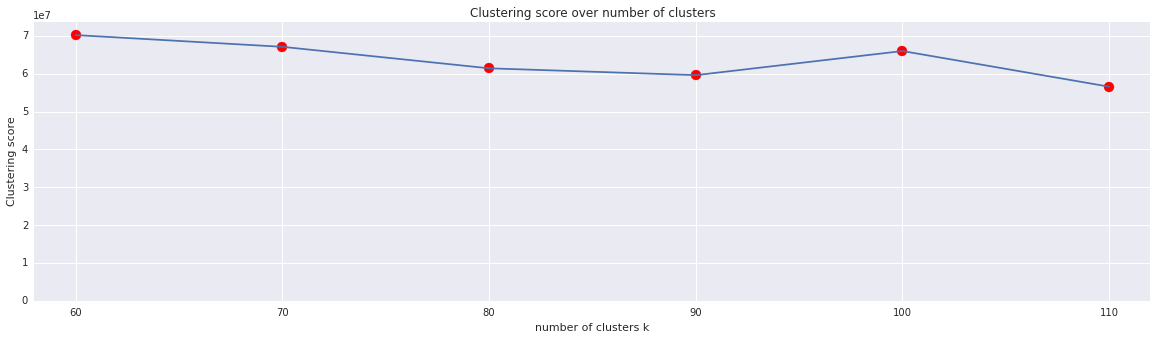

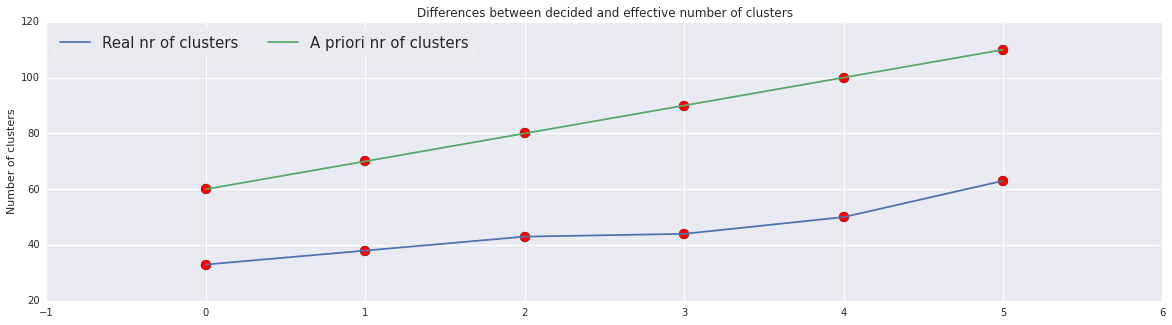

In [37]:
# plot results
plt.figure(figsize=(20,5))
_ = [_[0] for _ in scores]
plt.scatter(k_vector, _, color="r", s=100)
plt.plot(k_vector, _)
plt.axis([58,112, 0.85*np.min(scores), 1.05*np.max(scores)])
plt.xlabel("number of clusters k")
plt.ylabel("Clustering score")
plt.title("Clustering score over number of clusters")
plt.xticks(k_vector)
plt.show()

# plot results
plt.figure(figsize=(20,5))
_ = [_[1] for _ in scores]
plt.scatter(np.arange(len(k_vector)), _, c="r", s=100)
plt.scatter(np.arange(len(k_vector)), k_vector, c="r", s=100)
plt.plot(np.arange(len(k_vector)), _, label="Real nr of clusters")
plt.plot(np.arange(len(k_vector)), k_vector, label="A priori nr of clusters")
plt.ylabel("Number of clusters")
#plt.xticks(np.arange(len(k_vector)), k_vector)
plt.title("Differences between decided and effective number of clusters")
plt.legend(ncol=2, loc='upper left', frameon=True, fontsize=15)
#for i in np.arange(len(k_vector)):
#        plt.annotate(str(_[i]), i*0.98, _[i]*0.98)
#        plt.annotate(str(k_vector[i]), i*1.01, k_vector[i]*1.01)
plt.show()

<div class='alert alert-success'>
First of all, before commenting the plot, we notice one important fact:
<br>
<ul>
<li>The scale for the WSSSE dropped consistently from a magnitude of $10^{18}$ to a magnitude of $10^{7}$ 
</ul>
<br>
Other than this, we can still see the trend that increasing the number of clusters reduces the clustering score although here is much less visible since the number of clusters is really high.
<br><br>
Also, plotting the real and the expected number of clusters, we can see that the trend is always similiar and that the effective clusters are always much smaller (almost half) of the expected ones.
</div>

#### Question 9
<div class="alert alert-info">

Plot the clustering result to see the difference between before and after normalizing features. Discuss about the difference and explain why and if normalization was useful.

</div>

In [38]:
#let's use k as the best in the previous question = 80
clusters = KMeans.train(normalizedData, k=80, maxIterations=10, runs=10, initializationMode="random")

#get three axis on the first three attributes
sampledNormalized = normalizedData.sample(withReplacement=False, fraction=0.01)
datax_norm = sampledNormalized.map(lambda x: x[0]).collect()
datay_norm = sampledNormalized.map(lambda x: x[1]).collect()
dataz_norm = sampledNormalized.map(lambda x: x[2]).collect()
labels_norm = sampledNormalized.map(lambda x: clusters.predict(x)).collect()

#let's do also pca to see the difference
vectorData = normalizedData.map(Vectors.dense)
PCAModel = PCAmllib(3).fit(vectorData)
pcaData = PCAModel.transform(vectorData).sample(withReplacement=False, fraction=0.01).collect()

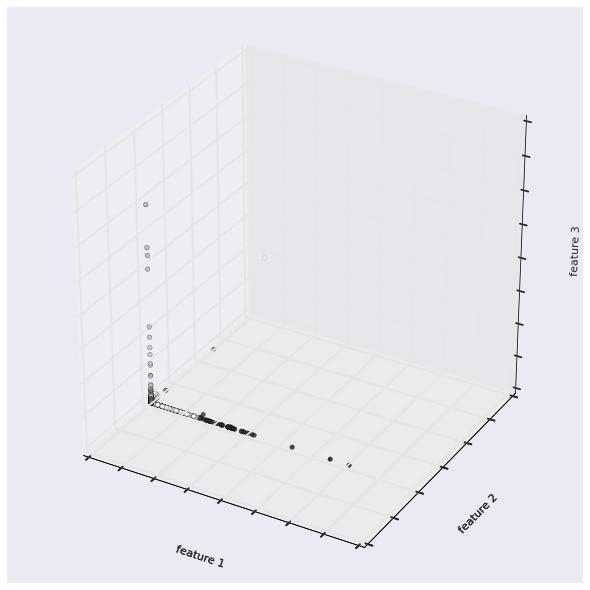

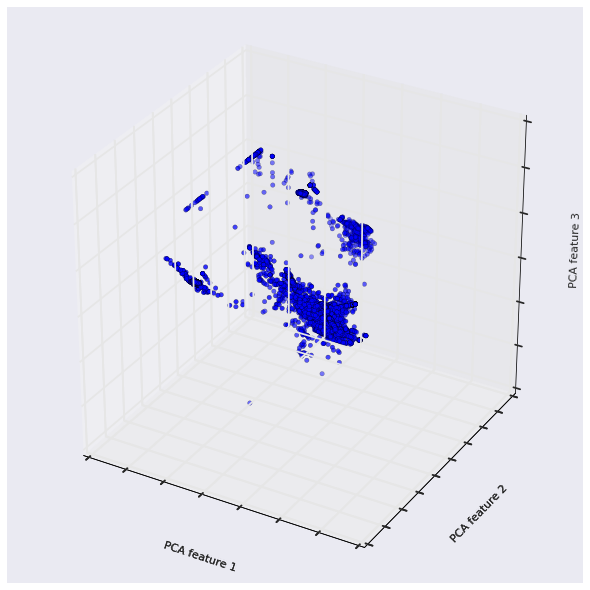

In [39]:
#plots
fig = plt.figure(1, figsize=(8, 8))
plt.clf()
ax = Axes3D(fig)
plt.cla()

ax.scatter(datax_norm, datay_norm, dataz_norm, c=labels_norm)

ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([])
ax.set_xlabel('feature 1')
ax.set_ylabel('feature 2')
ax.set_zlabel('feature 3')

plt.show()

#pca plot
fig = plt.figure(1, figsize=(8, 8))
plt.clf()
ax = Axes3D(fig)
plt.cla()

ax.scatter([x[0] for x in pcaData], [x[1] for x in pcaData], [x[2] for x in pcaData])

ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([])
ax.set_xlabel('PCA feature 1')
ax.set_ylabel('PCA feature 2')
ax.set_zlabel('PCA feature 3')

plt.show()

<div class="alert alert-success">
Normalizing values allowed a more standard variance for the different attributes and we can see the improvements in both plots.
<br><br>
The first plot is done with the first three features and this is to show that even if we normalize the data, and so the values change, the relationship between different points remain the same in fact, if you have a look at the first plot in question 3, it didn't change at all (without considering the colors that are random for each class).
<br><br>
The second plot is more interesting and shows a sample of 1% of the data plotted on the first three principal components.
<br><br>
If we look side by side at this plot and at the PCA plot in question 3, we can see that thanks to data normalization, the data is spread more equally on the different principal components. We can see that the data is not packed together like it was before and so this may improve our anomaly detection thanks to a better division of clusters.
</div>

## 2.3. Clustering using categorical features

### 2.3.1 Loading data

In the previous section, we ignored the categorical features of our data: this is not a good idea, since these categorical features can be important in providing useful information for clustering.
The problem is that K-means (or at least, the one we have developed and the one we use from MLLib) only work with data points in a metric space. Informally, this means that operations such as addition, subtraction and computing the mean of data points are trivial and well defined. For a more formal definition of what a metric space is, follow this [link](https://en.wikipedia.org/wiki/Metric_space#Definition).

What we will do next is to transform each categorical feature into one or more numerical features. This approach is very widespread: imagine for example you wanted to use K-means to cluster text data. Then, the idea is to transform text data in $d$-dimensional vectors, and a nice way to do it is to use [word2vec](http://deeplearning4j.org/word2vec). If you're interested, follow this link to a nice [blog post](http://bigdatasciencebootcamp.com/posts/Part_3/clustering_news.html) on the problem.

There are two approaches:

* **Approach 1**: mapping **one** categorical feature to **one** numerical feature. The values in each categorical feature are encoded into unique numbers of the new numerical feature. For example, ['VERY HOT','HOT', 'COOL', 'COLD', 'VERY COLD'] will be encoded into [0,1,2,3,4,5]. However, by using this method, we implicit assume that the value of 'VERY HOT' is smaller than 'HOT'... This is not generally true.

* **Approach 2**: mapping **one** categorical feature to **multiple** numerical features. Basically, a single variable with $n$ observations and $d$ distinct values, to $d$ binary variables with $n$ observations each. Each observation indicating the presence (1) or absence (0) of the $d^{th}$ binary variable. For example, ['house', 'car', 'tooth', 'car'] becomes 
```
[
[1,0,0,0],
[0,1,0,0],
[0,0,1,0],
[0,0,0,1],
]
```

We call the second approach "one-hot encoding". By using this approach, we keep the same role for all values of categorical features.



#### Question 10

<div class="alert alert-info">

Calculate the number of distinct categorical features value (at index `1,2,3`). Then construct a new input data using one-hot encoding for these categorical features (don't throw away numerical features!).

</div>

In [20]:
feat1 = raw_data.map(lambda x : x.split(",")[1]).distinct().collect()
feat2 = raw_data.map(lambda x : x.split(",")[2]).distinct().collect()
feat3 = raw_data.map(lambda x : x.split(",")[3]).distinct().collect()

In [41]:
print("feature 1: length = %d\nfeatures = \n%s\n" %(len(feat1), feat1))
print("\nfeature 2: length = %d\nfeatures = \n%s\n" %(len(feat2), feat2))
print("\nfeature 3: length = %d\nfeatures = \n%s\n" %(len(feat3), feat3))

feature 1: length = 3
features = 
['udp', 'tcp', 'icmp']


feature 2: length = 70
features = 
['whois', 'pop_3', 'harvest', 'uucp_path', 'systat', 'ecr_i', 'other', 'tftp_u', 'vmnet', 'time', 'remote_job', 'http', 'Z39_50', 'ftp', 'netbios_dgm', 'kshell', 'name', 'ldap', 'domain_u', 'discard', 'printer', 'eco_i', 'sunrpc', 'http_2784', 'sql_net', 'private', 'nnsp', 'finger', 'daytime', 'pop_2', 'exec', 'urp_i', 'iso_tsap', 'IRC', 'ftp_data', 'netbios_ns', 'http_443', 'urh_i', 'bgp', 'ctf', 'hostnames', 'domain', 'klogin', 'netstat', 'ssh', 'nntp', 'login', 'imap4', 'aol', 'mtp', 'tim_i', 'rje', 'shell', 'csnet_ns', 'efs', 'smtp', 'X11', 'telnet', 'pm_dump', 'supdup', 'red_i', 'http_8001', 'courier', 'echo', 'link', 'uucp', 'netbios_ssn', 'gopher', 'auth', 'ntp_u']


feature 3: length = 11
features = 
['SH', 'OTH', 'S1', 'REJ', 'S2', 'RSTOS0', 'RSTO', 'S0', 'RSTR', 'S3', 'SF']



<div class="alert alert-success">
Let's plot the data and see how this categorical features split the data.
</div>

In [42]:
f1 = raw_data.map(lambda x : x.split(",")[1]).map(lambda x : (x, 1)).reduceByKey(add).collect()
f2 = raw_data.map(lambda x : x.split(",")[2]).map(lambda x : (x, 1)).reduceByKey(add).collect()
f3 = raw_data.map(lambda x : x.split(",")[3]).map(lambda x : (x, 1)).reduceByKey(add).collect()

f1.sort(key=lambda x : x[1], reverse=True)
f2.sort(key=lambda x : x[1], reverse=True)
f3.sort(key=lambda x : x[1], reverse=True)

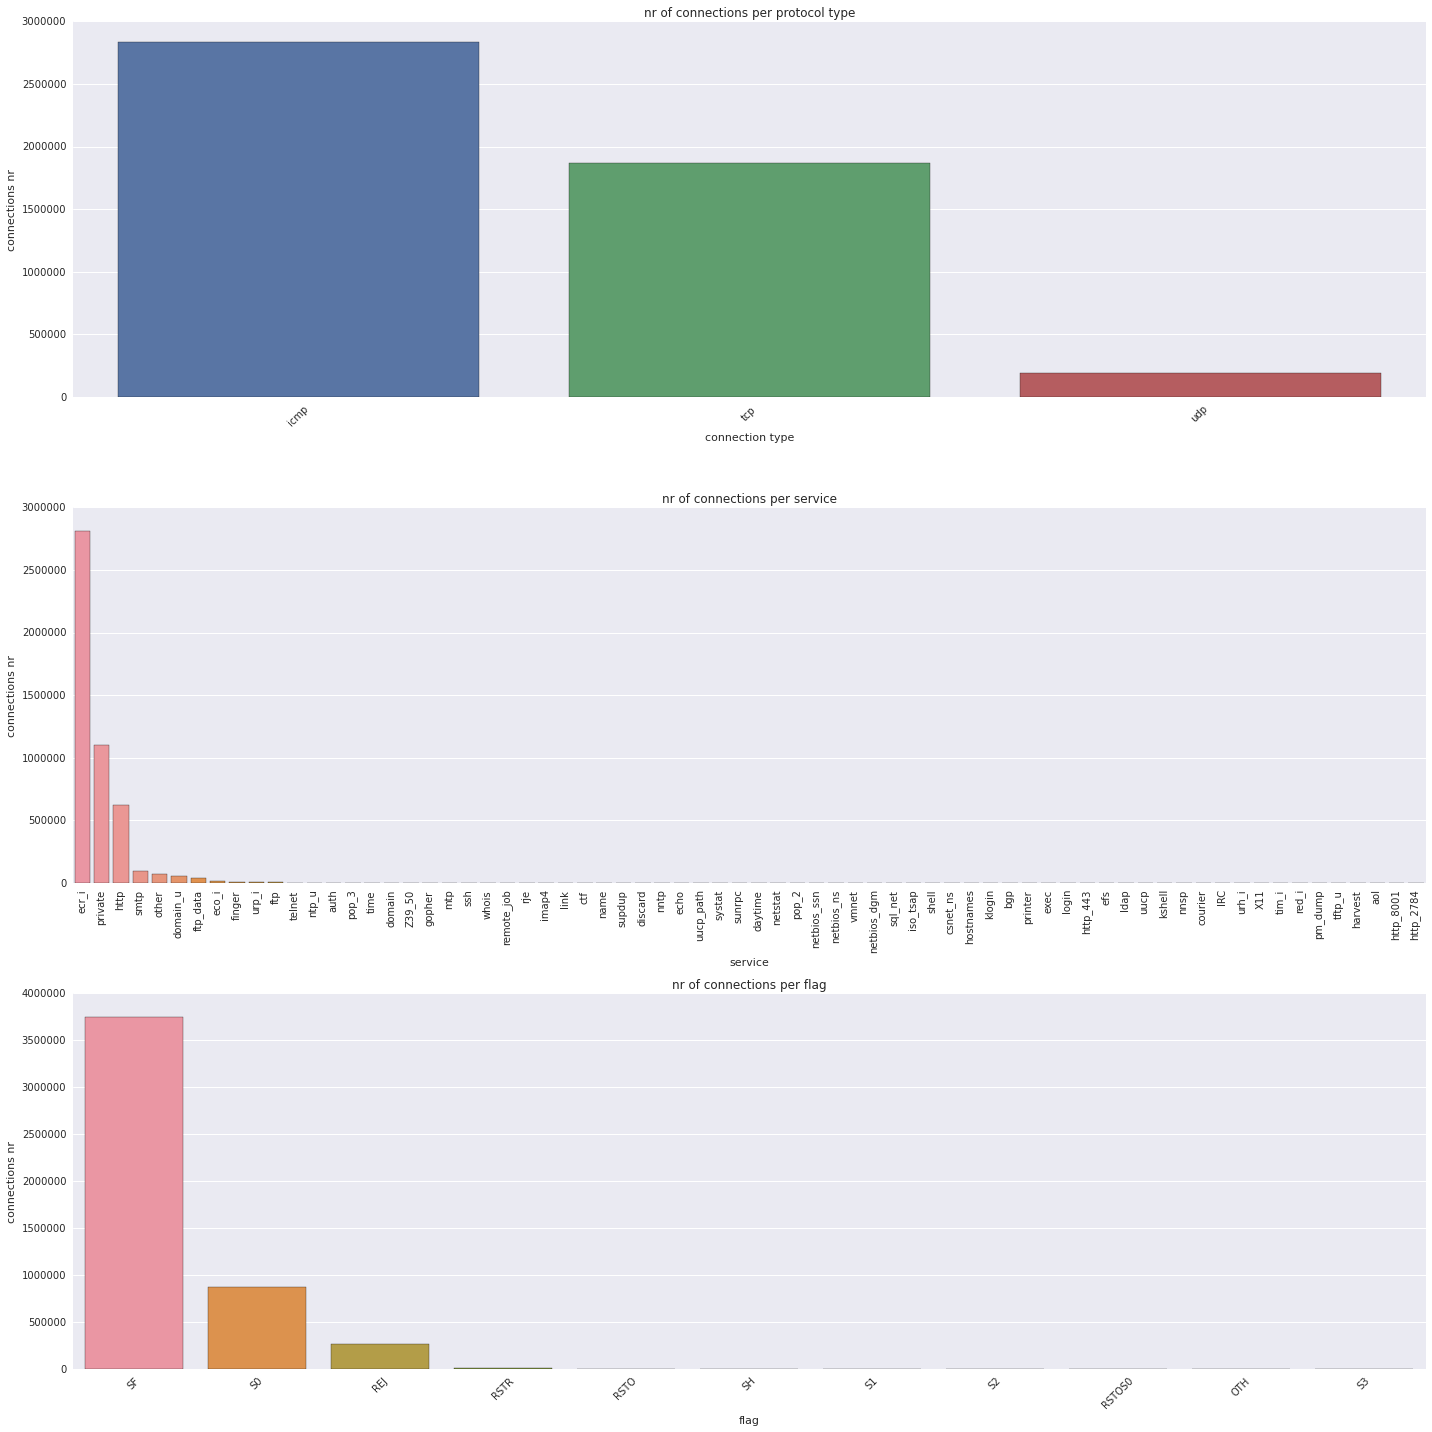

In [43]:
#plotting
a = plt.figure(figsize=(20,20))
plt.subplot(311)
sns.barplot(x=np.arange(len(f1)), y=[_[1] for _ in f1])
plt.xticks(np.arange(len(f1)), [_[0] for _ in f1], rotation=45)
plt.title("nr of connections per protocol type")
plt.xlabel("connection type")
plt.ylabel("connections nr")

plt.subplot(312)
sns.barplot(x=np.arange(len(f2)), y=[_[1] for _ in f2])
plt.xticks(np.arange(len(f2)), [_[0] for _ in f2], rotation="vertical")
plt.title("nr of connections per service")
plt.xlabel("service")
plt.ylabel("connections nr")

plt.subplot(313)
sns.barplot(x=np.arange(len(f3)), y=[_[1] for _ in f3])
plt.xticks(np.arange(len(f3)), [_[0] for _ in f3], rotation=45)
plt.title("nr of connections per flag")
plt.xlabel("flag")
plt.ylabel("connections nr")

plt.tight_layout()

plt.show()

<div class="alert alert-success">
We are trying to take account of all the different attributes we have at our disposal. Initially we didn't care about the categorical attributes (index 1,2,3) but now, with Hot Encoding, we are trying to see if the clustering with also this attributes becomes better.
<br><br>
Before using this new, more complete, data, let's see how this features separate our data set of nearly 5 million elements.
<br><br>
The first attribute describes the connection type and can take 3 values, tcp, udp and icmp. The data is almost equally divided between icmp and tcp, leaving less than 50 thousand connections to udp.
<br><br>
The second attribute describes the service and the third attribute describes the flags. As we can see, unfortunately, both this attributes concentrate much of the data in just 3 or 4 labels out of the 70, for the second attribute, and 11, for the third attribute.
<br><br>
We wrote <i>unfortunately</i> because having a not-so-distributed division of the data make us think that the clustering will not improve that much leaving the data as packed as before.
</div>

In [21]:
def parseLineWithHotEncoding(line):
    cols = line.split(",")
    # label is the last column
    label = cols[-1]
    
    vector = cols[0:-1]
    
    # the binary features that are encoded from the first categorical feature
    featureOfCol1 = [0]*len(feat1)
    featureOfCol1[feat1.index(vector[1])] = 1
    # the binary features that are encoded from the second categorical feature
    featureOfCol2 = [0]*len(feat2)
    featureOfCol2[feat2.index(vector[2])] = 1
    # the binary features that are encoded from the third categorical feature
    featureOfCol3 = [0]*len(feat3)
    featureOfCol3[feat3.index(vector[3])] = 1
    
    # construct the new vector
    vector = ([vector[0]] + featureOfCol1 + featureOfCol2 + 
        featureOfCol3 + vector[4:])
    
    # convert each value from string to float
    vector = np.array(vector, dtype=np.float)
    
    return (label, vector)

labelsAndData = raw_data.map(parseLineWithHotEncoding)

# we only need the data, not the label
#data = labelsAndData.values().cache()

#with our normalizeData function, we can simply do:
labelsAndDataNorm = normalizeData(labelsAndData).cache()
normalizedData = labelsAndDataNorm.map(lambda x:x[1]).cache()

### 2.3.2. Building models

#### Question 11
<div class="alert alert-info">

Using the new data, cluster the connections with different values of $k \in [80,90,100,110,120,130,140,150,160]$.
Evaluate the results and choose the best value of $k$ as previous questions.

</div>

In [49]:
k_vector = [20,30,40,50,60,70,80,90,100,110,120,130,140,150,160]
scores = [clusteringScore(normalizedData, k, withCenters=True) for k in k_vector]
for i, score in enumerate(scores):
    print("k = %3d, (effective nr. of clusters = %3d) WSSSE = %d" %(k_vector[i], score[1], score[0]))

k =  20, (effective nr. of clusters =  10) WSSSE = 443822810
k =  30, (effective nr. of clusters =  15) WSSSE = 433723084
k =  40, (effective nr. of clusters =  22) WSSSE = 409173638
k =  50, (effective nr. of clusters =  28) WSSSE = 394226990
k =  60, (effective nr. of clusters =  29) WSSSE = 382043897
k =  70, (effective nr. of clusters =  34) WSSSE = 354347537
k =  80, (effective nr. of clusters =  36) WSSSE = 351912887
k =  90, (effective nr. of clusters =  41) WSSSE = 343445347
k = 100, (effective nr. of clusters =  52) WSSSE = 305631444
k = 110, (effective nr. of clusters =  57) WSSSE = 322813820
k = 120, (effective nr. of clusters =  55) WSSSE = 316249625
k = 130, (effective nr. of clusters =  61) WSSSE = 281437387
k = 140, (effective nr. of clusters =  70) WSSSE = 274984948
k = 150, (effective nr. of clusters =  76) WSSSE = 289105418
k = 160, (effective nr. of clusters =  84) WSSSE = 277545099


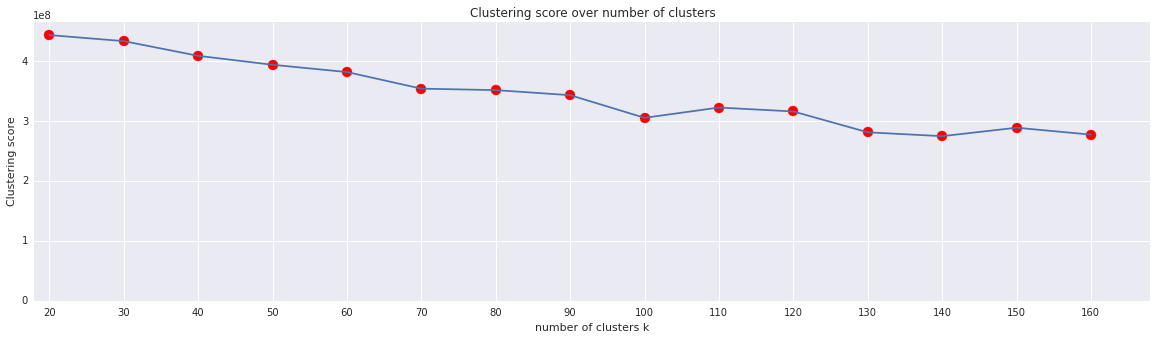

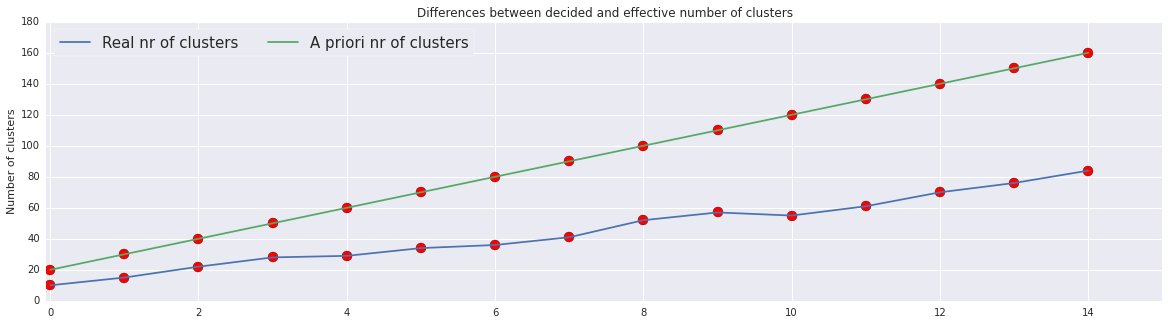

In [50]:
# plot results
plt.figure(figsize=(20,5))
_ = [_[0] for _ in scores]
plt.scatter(k_vector, _, color="r", s=100)
plt.plot(k_vector, _)
plt.axis([18, 1.05*np.max(k_vector), 0.85*np.min(scores), 1.05*np.max(scores)])
plt.xlabel("number of clusters k")
plt.ylabel("Clustering score")
plt.title("Clustering score over number of clusters")
plt.xticks(k_vector)
plt.show()

# plot results
plt.figure(figsize=(20,5))
_ = [_[1] for _ in scores]
plt.scatter(np.arange(len(k_vector)), _, c="r", s=100)
plt.scatter(np.arange(len(k_vector)), k_vector, c="r", s=100)
plt.plot(np.arange(len(k_vector)), _, label="Real nr of clusters")
plt.plot(np.arange(len(k_vector)), k_vector, label="A priori nr of clusters")
plt.ylabel("Number of clusters")
plt.xlim([-0.05, np.max(len(k_vector))])
#plt.xticks(np.arange(len(k_vector)), k_vector)
plt.title("Differences between decided and effective number of clusters")
plt.legend(ncol=2, loc='upper left', frameon=True, fontsize=15)
#for i in np.arange(len(k_vector)):
#        plt.annotate(str(_[i]), i*0.98, _[i]*0.98)
#        plt.annotate(str(k_vector[i]), i*1.01, k_vector[i]*1.01)
plt.show()

<div class="alert alert-success">
In our opinion, checking the clsutering score for just clusters with 80+ clusters up to 160 didn't make a lot of sense. We want to see also how it performs with a smaller $k$, but still enough large to contain all the possible labels. This is why we increased the <code>k_vector</code> from 20 up to 160.
<br><br>
As before, we plotted both the trend of the clustering score and the relationship between effective and desired number of clusters.
<br><br>
As we can see, the clustering score improves as $k$ increases, but remains almost the same from k=100 onwards.
<br>
We can also see a first "bump" when $k$ increases from 80 to 90 that is the best improvement we were able to get from one hop to the next one.
<br><br>
This is why, we'll try to perform the next tests, anomaly detection and silhouette with $k$ = 90.
</div>

## 2.4. Anomaly detection
When we have a new connection data (e.g., one that we never saw before), we simply find the closest cluster for it, and use this information as a proxy to indicate whether the data point is anomalous or not. A simple approach to decide when there is an anomaly or not, amounts to measuring the new data point’s distance to its nearest centroid. If this distance exceeds some thresholds, it is anomalous.

#### Question 12
<div class="alert alert-info">

Build your model with the best value of $k$ in your opinion. Then, detect the anomalous connections in our data. Plot and discuss your result.

</div>

<div class="label label-success">HINT</div> The threshold has strong impact on the result. Be careful when choosing it! A simple way to choose the threshold's value is picking up a distance of a data point from among known data. For example, the 100th-farthest data point distance can be an option.

In [22]:
bestK = 90

In [23]:
clusters = KMeans.train(normalizedData, bestK, maxIterations=10, runs=10, initializationMode="random")

In [24]:
print("Initial k clusters:", bestK)
print("Effective clusters:", len(clusters.centers))

Initial k clusters: 90
Effective clusters: 41


<div class="alert alert-success">
Even here we can see that even though we start with 120 clusters, the model degenerates to only 68 clusters since some of them remain with 0 elements.
</div>

In [54]:
ordered = normalizedData.map(lambda x : (error(clusters, x), x)).takeOrdered(10000, lambda key : -key[0])

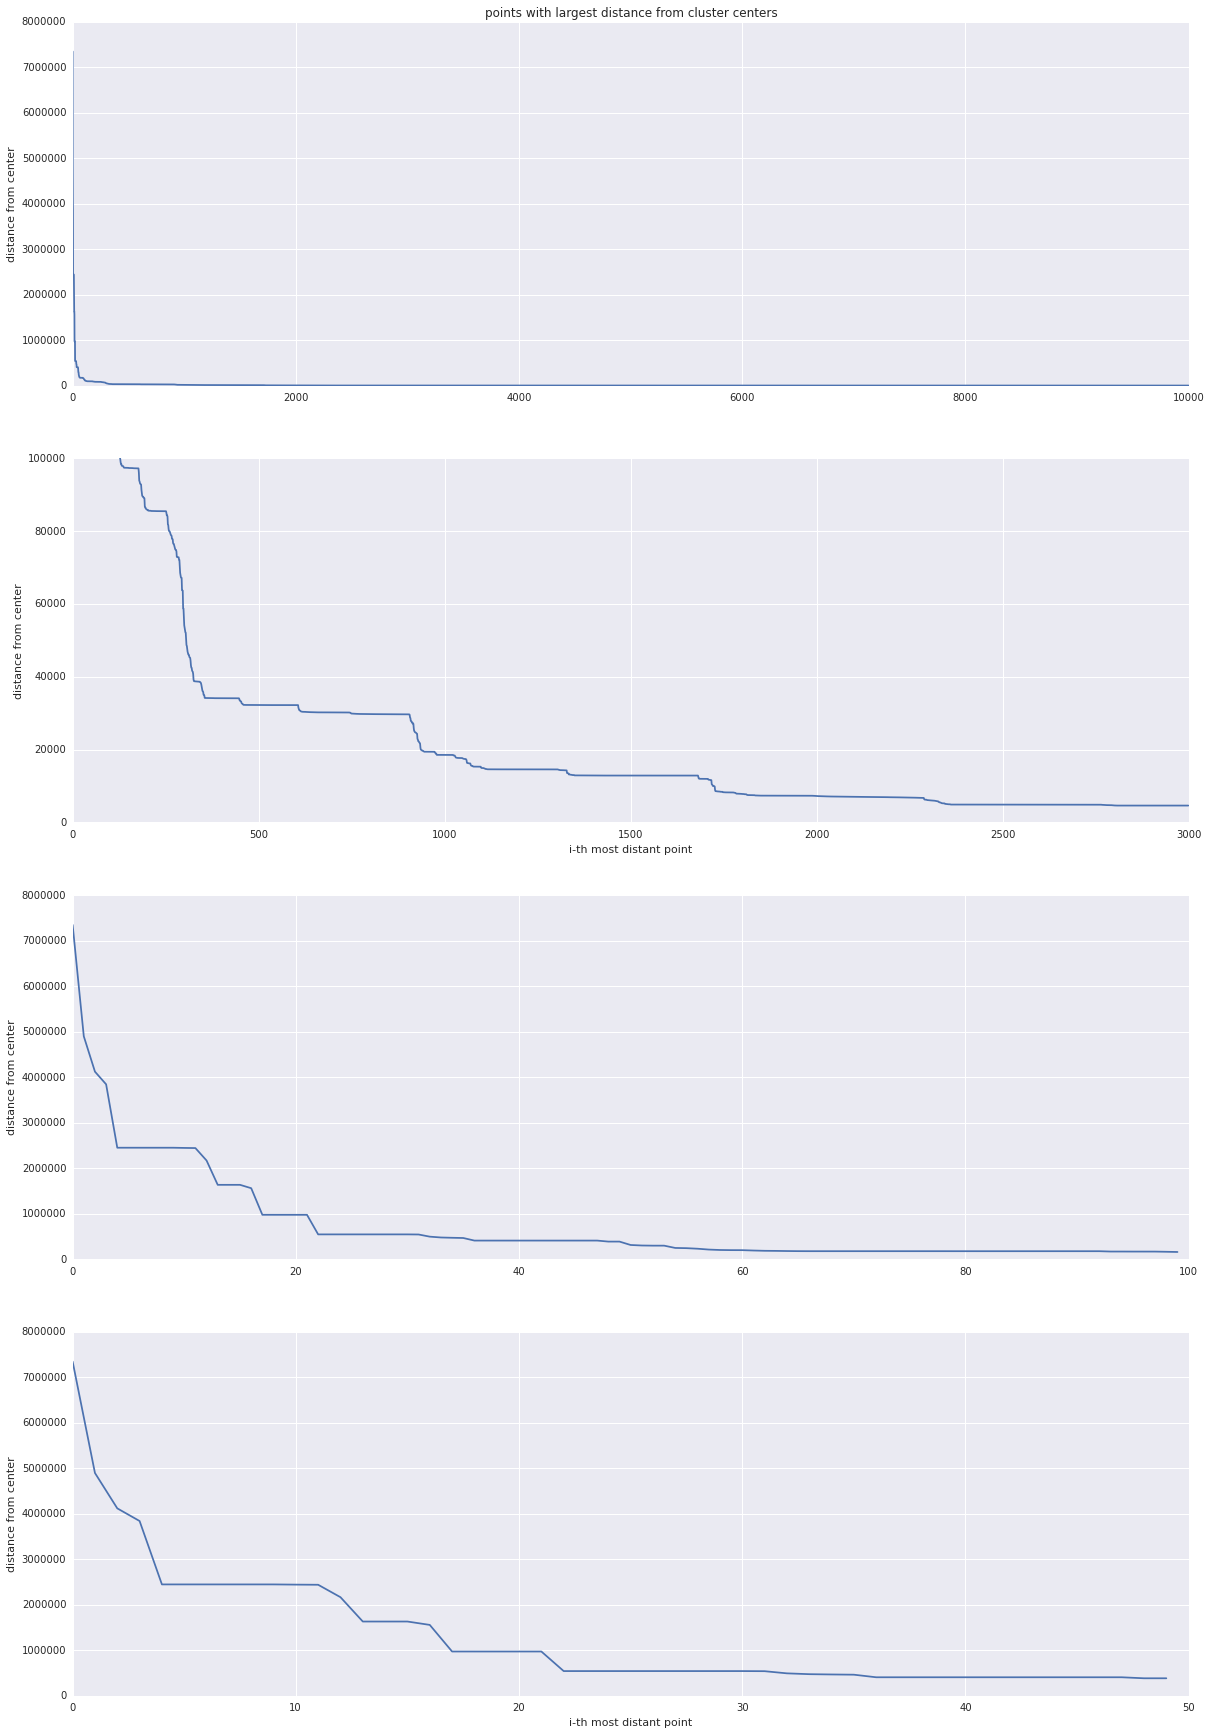

In [55]:
xx = [x[0] for x in ordered]
plt.figure(figsize=(20,30))
plt.subplot(411)
plt.plot(xx)
plt.title("points with largest distance from cluster centers")
plt.ylabel("distance from center")

plt.subplot(412)
plt.plot(xx[:3000])
plt.ylabel("distance from center")
plt.xlabel("i-th most distant point")
plt.ylim(0,100000)

plt.subplot(413)
plt.plot(xx[:100])
plt.ylabel("distance from center")

plt.subplot(414)
plt.plot(xx[:50])
plt.ylabel("distance from center")
plt.xlabel("i-th most distant point")
plt.show()

<div class="alert alert-success">
The first plot shows the 10000 points with the largest distance from the cluster. As we can see, after an initial peak of 30 (probably the anomalous connections), the distance from the cluster tends to get smaller. This means that the majority of the clusters are packed up together and the outliers could be easily detected.
<br><br>
The second plot is a zoom in of just the bottom part (with a limit on the y range) and we can see that actually zooming in, the plot continues to slope down until 2400-2500 connections and then stays to a "small" distance for the rest of the plot.
<br><bR>
The next two plots are just a zoom in on the top-100 and top-50 furthest connections.
<br><br>
Other than the first plot, this zoom-in allow us to decide which is the best threshold to use to divide anomalous connections from the normal ones.
<br><br>
As we can see, the first 20/30 points span a distance from 1 million to 7 million, and considering the first 2500 points (remember that the full dataset is 5 million points so 2500 points is just 0.05%) the distance drops from 7 million to almost 5000. This number alone doesn't say a lot, since to evaluate the error the distance is squared, but noticing that after that slope the distance is almost constant makes us think to put that number as threshold.
<br><br>
We can try to plot the nr of anomalous connections per threshold to have a better idea:
</div>

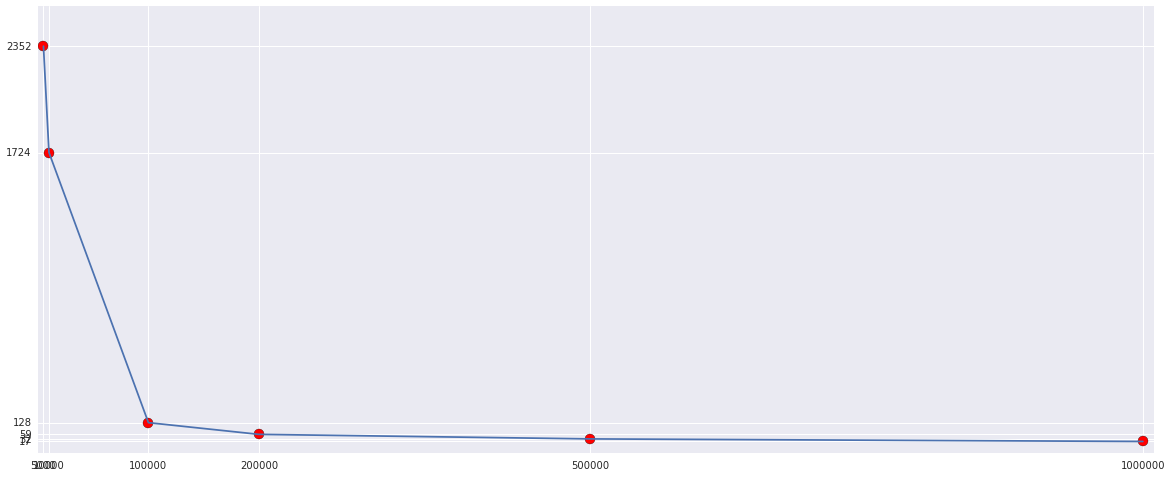

Threshold:    1000000	anomalous connections:    17
Threshold:     500000	anomalous connections:    32
Threshold:     200000	anomalous connections:    59
Threshold:     100000	anomalous connections:   128
Threshold:      10000	anomalous connections:  1724
Threshold:       5000	anomalous connections:  2352


In [56]:
thresholds = [1000000, 500000, 200000, 100000, 10000, 5000]
t_count = [len([__ for __ in xx if __ > _]) for _ in thresholds]

plt.figure(figsize=(20,8))
plt.scatter(thresholds, t_count, c="r", s=100)
plt.plot(thresholds, t_count)
plt.yticks(t_count)
plt.xticks(thresholds)
plt.ylim(-50, np.max(t_count)*1.1)
plt.xlim(0, np.max(thresholds)*1.01)
plt.show()

for i in range(len(thresholds)):
    print("Threshold: %10d\tanomalous connections: %5d" %(thresholds[i], t_count[i]))

<div class="alert alert-success">
This plot shows the number of connections we would label as anomalous if we would select a certain threshold. As obvious, increasing the threshold will determine less anomalous connections.
<br><br>
An important thing to know is that for a company that has to automatically label anomalous connections for, let's say, further checks, it's better to "grab" and then check all true anomalous connections together with some non-anomalous connections than leave unchecked some true anomalous connections.
<br><br>
This problem is well known and states that it's not a good metric to see the accuracy of a model because, taking this case as an example, since the anomalous connections would be relatively small, let's say 0.5%, if we would state that everything is non-anomalous we would still get an accuracy of 99.5% <i>but</i> the accuracy would be high just thanks to the ratio between anomalous and non-anomalous connections.
<br><br>
To begin with, we would start putting as a threshold 5000 and so evaluating 2323 connections as anomalous (the numbers will change when we run again the notebook).
<br>
Let's try to print this connections and see what are their labels.
</div>

In [25]:
currThre = 5000
y = labelsAndDataNorm.map(lambda x : (x[0], error(clusters, x[1]))).filter(lambda x: x[1]>currThre) \
                    .map(lambda x : (x[0], 1)).reduceByKey(add).collect()

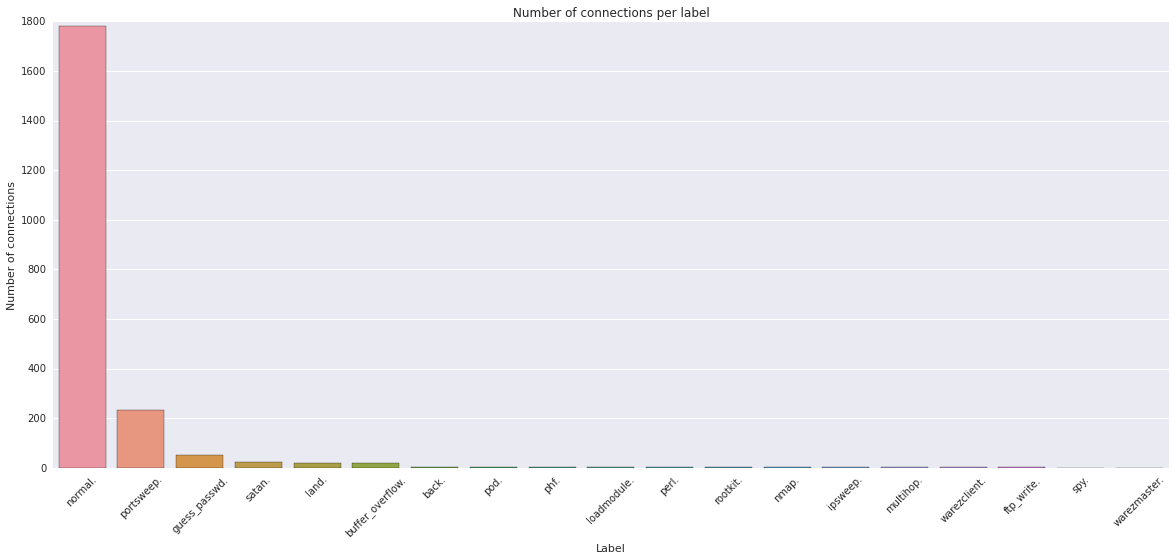

In [26]:
y.sort(key=lambda x : x[1], reverse=True)
plt.figure(figsize=(20,8))
sns.barplot(x=np.arange(len(y)), y=[_[1] for _ in y])
plt.xticks(np.arange(len(y)), [_[0] for _ in y], rotation=45)
plt.xlabel("Label")
plt.ylabel("Number of connections")
plt.title("Number of connections per label")
plt.show()

<div class="alert alert-danger">
TODO comment plot above
</div>

#### Question 13
<div class="alert alert-info">

Try other methods to find the best value for $k$ such as `silhouette`, `entropy`... In particular, with this data, you can take advantage of predefined labels to calculate the quality of model using entropy... However, we suggest you to try with `silhouette`. It's more general and can work with any dataset (with and without predefined labels).

</div>

Here are some additional information about the metrics we suggest to use:
- <a href="https://en.wikipedia.org/wiki/Silhouette_(clustering)">Silhouette</a>
- [Hack approach to Silhouette](http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html)
- [Entropy](http://scikit-learn.org/stable/modules/clustering.html) [Lookup for entropy]

<div class="label label-danger">Note</div> you are free to play with any relevant evaluation metric you think appropriate for your work!

<div class="alert alert-warning">
<h3>Entropy</h3>
</div>

<div class="alert alert-success">
Entropy is another measure for the goodness of a clustering model over some data.
<br><br>
The total entropy of a clustering is:
\begin{equation}
H(\Omega) = \sum_{\omega\in\Omega} H({\omega})\frac{N_\omega}{N}
\end{equation}
where
<ul>
<li>$\Omega=\{\omega_1,\omega_2,\dots,\omega_k\}$ is the set of clusters,
<li>$H(\omega)$ is the entropy of a single cluster,
<li>$N_\omega$ is the number of points in cluster $w$,
<li>$N$ is the total number of points.
</ul>
The entropy of a single cluster is defined as:
\begin{equation}
H(\omega) = - \sum_{c\in C}P(\omega_c)log_2P(\omega_c)
\end{equation}
or, when substituting the probabilities with the Maximum Likelihood Estimate, as:
<br><br>
\begin{equation}
H(\omega) = - \sum_{c\in C}\frac{\vert{\omega_c}}{n_\omega}log_2\frac{\vert{\omega_c}}{n_\omega}
\end{equation}
<br>
where
<ul>
<li>$\omega_c$ is the amount of points with label $c$ in cluster $\omega$,
<li>$n_\omega$ is the number of points in cluster $\omega$
</ul>
<br><br>
Our definition of entropy and our code below follow the definitions from the <a href="https://nlp.stanford.edu/IR-book/">Introduction to Information Retrieval</a> book from Stanford, more specifically <a href="https://nlp.stanford.edu/IR-book/html/htmledition/evaluation-of-clustering-1.html">this</a> chapter.
</div>

In [32]:
def label_entropy(label_count, cluster_count):
    ratio = label_count / cluster_count
    return -ratio * np.log2(ratio)

def clusteringEntropy(labeled_data, model):
    total = labeled_data.count()
    # returns the number of occurrency of each pair (label, assigned_cluster)
    labels_with_cluster = labeled_data.map(lambda x : ((x[0], model.predict(x[1])), 1)).reduceByKey(add).cache()
    # contains the number of element for each cluster
    labels_dist = labels_with_cluster.map(lambda x : (x[0][1], x[1])).reduceByKey(add).collectAsMap()
    labels_ratio = {key:labels_dist[key]/total for key in labels_dist}
    clusters_entropy = labels_with_cluster.map(lambda x: (x[0][1], label_entropy(x[1], labels_dist[x[0][1]])))\
                        .reduceByKey(add)
    total_entropy = clusters_entropy.map(lambda x : x[1]*labels_ratio[x[0]]).sum()
    return total_entropy

In [33]:
clusteringEntropy(labelsAndDataNorm, clusters)

0.031189781009926833

<div class="alert alert-danger">
TODO comment entropy
</div>

<div class="alert alert-warning">
<h3>Silhouette</h3>
</div>

<div class="alert alert-success">
Silhouette analysis can be used to study the separation distance between the resulting clusters.
<br><br>
The silhouette for each point is evaluated as:
\begin{equation}
sil = \frac{b(i)-a(i)}{max\{a(i),b(i)\}}
\end{equation}
<br>
where $a(i)$ represents the similiarity of point $i$ to its own cluster and $b(i)$ represents the dissimiliarity with respect to the neighbouring cluster (the second nearest). We can define $a(i)$ as how well the point is assigned to its cluster and $b(i)$ as how well it would have been assigned to the neighbour cluster.
<br><br>
In our evaluations, $a(i)$ represents the distance of the point $i$ to the center of its own cluster instead $b(i)$ represents the distance to the center of the neighbouring cluster or, in other words, the distance to the second nearest center.
<br><br>
Because of the definition of the $k$-means algorithm, we know for sure that $a(i)$ is smaller than $b(i)$ (otherwise point $i$ wouldn't have been assigned to its cluster, and so the formula can be rewritten as:
\begin{equation}
sil = 1 - \frac{a(i)}{b(i)}
\end{equation}
<br><br>
The silhouette is a value between -1 and +1 but in our case it's always a positive value between 0 and +1. If the value is high, near +1, it means that the point is close to its own center and distant from the neighbouring cluster instead if it's close to 0, it means that the point is nearly in the middle between two clusters and so the prediction is not so good.
<br><br>
Below, the code for plotting the silhouette. The code is inspired from <a href="http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html">here</a>.
</div>

In [59]:
import matplotlib.cm as cm

def plot_silhouette(clusters, data):
    t1 = time.time()
    
    def calc_silhouette(point, centers):
        nearest_centers = [euclidean_distance(_, point) for _ in centers]
        nearest_centers = sorted(nearest_centers)
        return 1-(nearest_centers[0]/nearest_centers[1])
    
    # Compute the silhouette scores for each sample
    centers = clusters.centers
    k = len(centers)
    bCenters = sc.broadcast(centers)
    sil = data.map(lambda x:(x, clusters.predict(x), calc_silhouette(x, bCenters.value))).cache()
    silhouette_avg = sil.map(lambda x:x[2]).mean()
    print("The average silhouette is:", silhouette_avg)
    
    fig, ax1 = plt.subplots(1, 1)
    fig.set_size_inches([20, k*3/8])
    ax1.set_xlim([-0.1, 1])
    y_lower = 10

    for i in range(k):
        ith_cluster_silhouette_values = sil.filter(lambda x:x[1] == i).sample(False, 0.5) \
                    .sortBy(lambda x:x[2]).map(lambda x:x[2]).collect()
        ith_cluster_silhouette_values = np.array(ith_cluster_silhouette_values)

        size_cluster_i = ith_cluster_silhouette_values.shape[0]

        y_upper = y_lower + size_cluster_i

        color = cm.spectral(float(i) / k)
        ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        if i % 5 == 0:
            ax1.text(-0.05, (y_lower + y_upper) / 2, str(i))


        y_lower = y_upper + 10 

    print("time taken:", time.time()-t1)
    
    ax1.set_title("The silhouette plot for the various clusters with K = "+str(k))
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")


    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    plt.show()

The average silhouette is: 0.774886135732
time taken: 438.248587846756


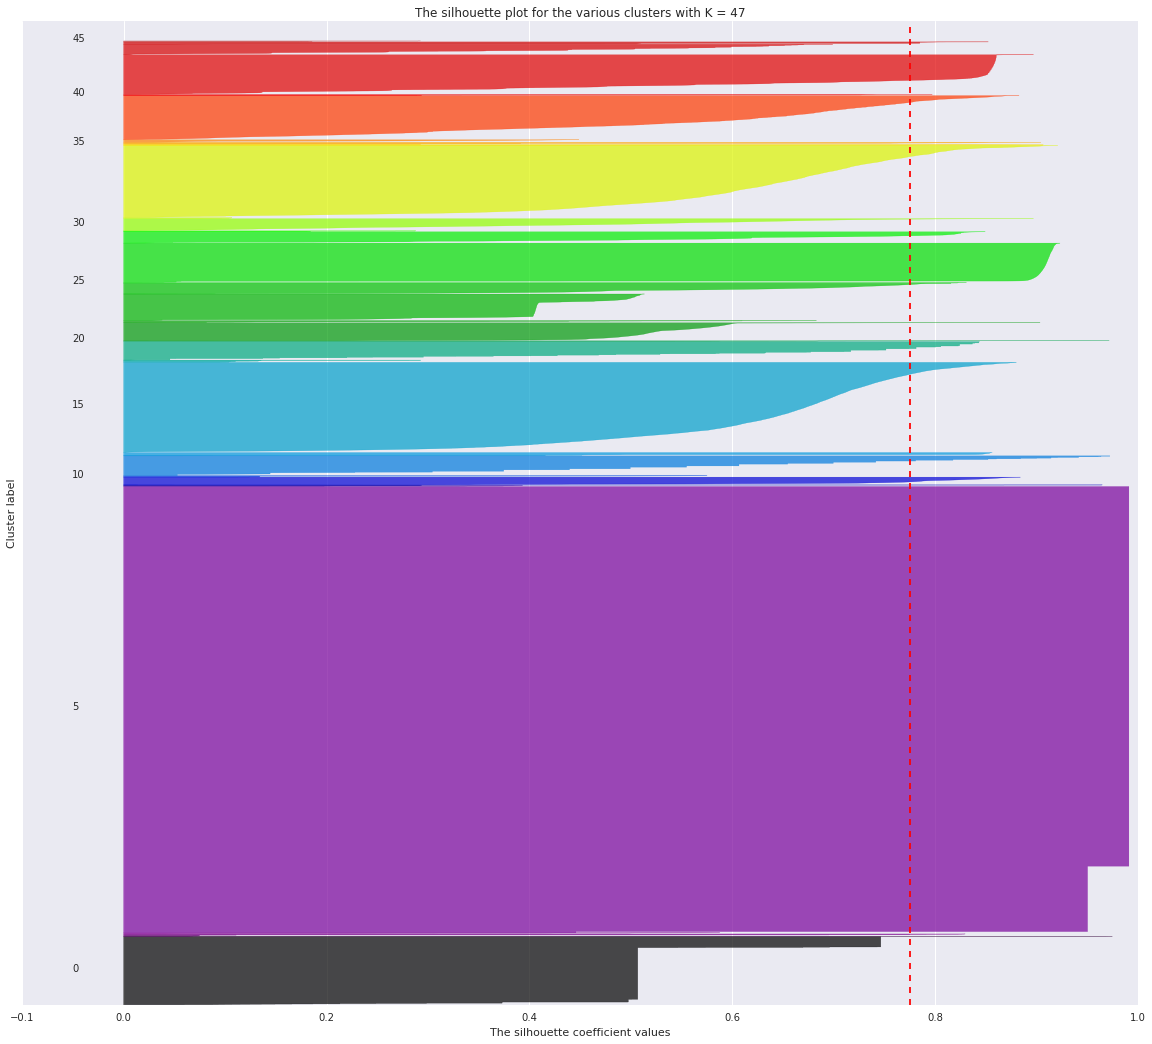

In [60]:
plot_silhouette(clusters, normalizedData)

<div class="alert alert-danger">
TODO comment silhouette
</div>

#### Question 14
<div class="alert alert-info">

Implement K-means on Spark so that It can work with large datasets in parallel. Test your algorithm with our dataset in this notebook. Compare our algorithm with the algorithm from MLLIB.  

<ul></ul>

Let's clarify the meaning of this question: what we want is for students to design the K-means algorithm for the parallel programming model exposed by Spark. You are strongly invited to use the Python API (pyspark). So, at the end of the day, you will operate on RDDs, and implement a `map/reduce` algorithm that performs the two phases of the standard K-means algorithm, i.e. the assignment step and the update step.

</div>

In [ ]:
from pyspark import AccumulatorParam

class VectorAccumulatorParam(AccumulatorParam):
    def zero(self, initialAcc):
        l = len(initialAcc)
        sums = np.zeros([l, 122])
        counts = np.zeros(l)
        return [sums, counts]

    def addInPlace(self, v1, v2):
        v1[0] += v2[0]
        v1[1] += v2[1]
        return v1

def mapping(iterator, centers):
    sums = np.zeros([len(centers), 122])
    counts = np.zeros(len(centers))
    for x in iterator:
        i = find_closest_centroid(x, centers)
        sums[i] += x
        counts[i] += 1
    acc.add([sums, counts])
    yield

def getError(centroids, data):
    bCentroids = sc.broadcast(centroids)
    return data.map(lambda x : euclidean_distance(bCentroids.value[find_closest_centroid(x, bCentroids.value)], x)) \
            .reduce(add)

def KMeansTrain(data, k=2, runs=1, maxIterations=20, centroids=None, threshold=0, verbose=False):
    bestError = float("inf")
    sums = np.zeros([k, len(normalizedData.first())])
    counts = np.zeros(k)
    initialAcc =  [sums, counts]
    bestCentroids = None
    
    if verbose is True:
        t0 = time.time()
    
    for _ in range(runs):
        
        if verbose is True:
            t1 = time.time()
            print("Starting run #",_)
        
        # randomize the centroids if they are not given
        if not centroids:
            centroids = data.takeSample(withReplacement=False, num=k)

        iterations = 0
        while True:
            iterations += 1

            #broadcast current centroids
            bCentroids = sc.broadcast(centroids)

            acc = sc.accumulator(initialAcc, VectorAccumulatorParam())
            global acc
            
            
            #assign each data point to the closest centroid
            data.mapPartitions(lambda iterator: mapping(iterator, bCentroids.value)).collect()
            #update centroids
            old_centroids = centroids
            centroids = np.array([s/c for s, c in zip(acc.value[0], acc.value[1])])

            # if the stop criteria are met, stop the algorithm
            if check_converge(old_centroids, bCentroids.value, iterations, threshold):
                break
        
        currError = getError(bCentroids.value, data)
        if currError < bestError:
            bestError = currError
            bestCentroids = centroids
        
        if verbose is True:
            t3 = time.time()
            print("Finished run #"+str(_)+"/"+str(runs),"in",t3-t1, "seconds; Total elapsed time:", t3-t0)
                    
    return bestCentroids

In [ ]:
myClusters = KMeansTrain(normalizedData, verbose=True)

Starting run # 0


<div class="alert alert-danger">
<h3>Conclusion</h3>
<br>
TODO
</div>